*NeurIPS* 2020 Offline RL Tutorial Colab Exercise
=====

This self-contained notebook contains a customizable gridworld environment with an implementation of q-iteration and FQI with neural networks, and some offline RL algorithms and diagnostic tools. This notebook is built on an awesome playground for value-based RL from Justin Fu, titled  value iteration playground which you can find here: https://drive.google.com/file/d/177mrb9B4rqNrdTLtZSgPRdCnrhVlJdEx/view. 

To use this notebook, create a copy in your drive or download it as a .ipynb file locally.

### Environment Setup
The environment is specified with a string. For example, the following code

```python
maze = spec_from_string("SOO\\"+
                        "O#R\\")

env = GridEnv(maze, teps=0.0)
```

Will create a 2x3 gridworld with a reward (R) on the bottom right tile, and the starting state (S) on the top right. A single wall (#) is in the bottom-middle tile. All other tiles (O) are empty spaces.

The `teps` argument specifies the amount of transition noise (probability a random action is taken instead of the specified action). A value of 0 produces a deterministic environment.

The environment follows a simple API:
- States and actions are represented as integers.
- `env.num_states` and `env.num_actions` returns the size of the state and action spaces.
- `env.initial_state_distribution()` returns a dictionary mapping from {state: probability}
- `env.transitions(s, a)` returns a dictionary mapping {next state: transition probability}.
- `env.reward(s, a, ns)` returns the reward (float) for taking a transition
- `env.observation(s)` returns the observation for a given state.

### Plotting

Two plotting functions are provided
 - `plot_sa_values(env, array)` plots state-action dependent values. This include Q-values, policies, etc. 
 - `plot_s_values(env, array)` plots state dependent values. This include value functions.

### Utility Functions

Additional utility functions are provided for algorithm diagnosis.
- `compute_policy_deterministic(q_values, eps_greedy=0.0)` returns an |S|x|A| policy probability matrix.
- `compute_visitation(env, policy, discount=1.0, T=50)` computes the (discounted) visitation distribution of a policy using T steps of forward propagation.

### Networks

The neural network (`FCNetwork`) can be called with a list of states (ints) and returns a state by action matrix of Q-values. You should not pass in observations (it automatically calls the observation function of the environment).

### Algorithms

This colab implements tabular RL algorithms (Q-iteration and policy iteration) along with an offline RL algorithm, conservative Q-learning.

### Datasets

1. **[Controlling for only distributional shift]** We provide the flexibility to play around with different dataset compositions by switching around the weighting distributions over state-action pairs that also provides the users a way to visualize how the dataset composition affects offline RL algorithms due to distributional shift.

2. **[Distributional shift + finite sampling error]** We also have variants of datasets that only contain finite samples. This indicates how the sampling error in an offline setting gets exacerbated due to distributional shift.

### **Experiments that you'll be running**

In this colab exercise, you will be running three experiments to understand the effects of different factors (dataset distributions, number of datapoints in the datasets and the strangth of the constraint/regularization against distributional shift) in offline RL algorithms on a gridworld environment.

As starting directions for understanding the effects of these factors, we provide several questions within the description of each experiment that could be fun to answer, while also being quite illustrative about problems arising in more complex tasks along with solutions to fix them.

Setup Code
-----

The following code should not need to be modified. 

Use Ctrl+F8 (Run Before) on a cell after this block to load all of the code.

In [1]:
#@title Imports

import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Rectangle, Polygon
from IPython.display import clear_output
import torch
import torch.nn as nn
%matplotlib inline  

In [23]:
#@title Environment Code
import sys

EMPTY = 110
WALL = 111
START = 112
REWARD = 113
OUT_OF_BOUNDS = 114
LAVA = 118

TILES = {EMPTY, WALL, START, REWARD, LAVA}

STR_MAP = {
    'O': EMPTY,
    '#': WALL,
    'S': START,
    'R': REWARD,
    'L': LAVA
}

RENDER_DICT = {v:k for k, v in STR_MAP.items()}
RENDER_DICT[EMPTY] = ' '
RENDER_DICT[START] = ' '


def spec_from_string(s, valmap=STR_MAP):
    if s.endswith('\\'):
        s = s[:-1]
    rows = s.split('\\')
    rowlens = np.array([len(row) for row in rows])
    assert np.all(rowlens == rowlens[0])
    w, h = len(rows[0]), len(rows)

    gs = GridSpec(w, h)
    for i in range(h):
        for j in range(w):
            gs[j,i] = valmap[rows[i][j]]
    return gs


def spec_from_sparse_locations(w, h, tile_to_locs):
    """

    Example usage:
    >> spec_from_sparse_locations(10, 10, {START: [(0,0)], REWARD: [(7,8), (8,8)]})

    """
    gs = GridSpec(w, h)
    for tile_type in tile_to_locs:
        locs = np.array(tile_to_locs[tile_type])
        for i in range(locs.shape[0]):
            gs[tuple(locs[i])] = tile_type
    return gs


def local_spec(map, xpnt):
    """
    >>> local_spec("yOy\\\\Oxy", xpnt=(5,5))
    array([[4, 4],
           [6, 4],
           [6, 5]])
    """
    Y = 0; X=1; O=2
    valmap={
        'y': Y,
        'x': X,
        'O': O
    }
    gs = spec_from_string(map, valmap=valmap)
    ys = gs.find(Y)
    x = gs.find(X)
    result = ys-x + np.array(xpnt)
    return result


class GridSpec(object):
    def __init__(self, w, h):
        self.__data = np.zeros((w, h), dtype=np.int32)
        self.__w = w
        self.__h = h

    def __setitem__(self, key, val):
        self.__data[key] = val

    def __getitem__(self, key):
        if self.out_of_bounds(key):
            raise NotImplementedError("Out of bounds:"+str(key))
        return self.__data[tuple(key)]

    def out_of_bounds(self, wh):
        """ Return true if x, y is out of bounds """
        w, h = wh
        if w<0 or w>=self.__w:
            return True
        if h < 0 or h >= self.__h:
            return True
        return False

    def get_neighbors(self, k, xy=False):
        """ Return values of up, down, left, and right tiles """
        if not xy:
            k = self.idx_to_xy(k)
        offsets = [np.array([0,-1]), np.array([0,1]),
                   np.array([-1,0]), np.array([1,0])]
        neighbors = \
            [self[k+offset] if (not self.out_of_bounds(k+offset)) else OUT_OF_BOUNDS for offset in offsets ]
        return neighbors

    def get_value(self, k, xy=False):
        """ Return values of up, down, left, and right tiles """
        if not xy:
            k = self.idx_to_xy(k)
        return self[k]

    def find(self, value):
        return np.array(np.where(self.spec == value)).T

    @property
    def spec(self):
        return self.__data

    @property
    def width(self):
        return self.__w

    def __len__(self):
        return self.__w*self.__h

    @property
    def height(self):
        return self.__h

    def idx_to_xy(self, idx):
        if hasattr(idx, '__len__'):  # array
            x = idx % self.__w
            y = np.floor(idx/self.__w).astype(np.int32)
            xy = np.c_[x,y]
            return xy
        else:
            return np.array([ idx % self.__w, int(np.floor(idx/self.__w))])

    def xy_to_idx(self, key):
        shape = np.array(key).shape
        if len(shape) == 1:
            return key[0] + key[1]*self.__w
        elif len(shape) == 2:
            return key[:,0] + key[:,1]*self.__w
        else:
            raise NotImplementedError()

    def __hash__(self):
        data = (self.__w, self.__h) + tuple(self.__data.reshape([-1]).tolist())
        return hash(data)
 

ACT_NOOP = 0
ACT_UP = 1
ACT_DOWN = 2
ACT_LEFT = 3
ACT_RIGHT = 4
ACT_DICT = {
    ACT_NOOP: [0,0],
    ACT_UP: [0, -1],
    ACT_LEFT: [-1, 0],
    ACT_RIGHT: [+1, 0],
    ACT_DOWN: [0, +1]
}
ACT_TO_STR = {
    ACT_NOOP: 'NOOP',
    ACT_UP: 'UP',
    ACT_LEFT: 'LEFT',
    ACT_RIGHT: 'RIGHT',
    ACT_DOWN: 'DOWN'
}

class TransitionModel(object):
    def __init__(self, gridspec, eps=0.2):
        self.gs = gridspec
        self.eps = eps

    def get_aprobs(self, s, a):
        # TODO: could probably output a matrix over all states...
        legal_moves = self.__get_legal_moves(s)
        p = np.zeros(len(ACT_DICT))
        p[legal_moves] = self.eps / (len(legal_moves))
        if a in legal_moves:
            p[a] += 1.0-self.eps
        else:
            #p = np.array([1.0,0,0,0,0])  # NOOP
            p[ACT_NOOP] += 1.0-self.eps
        return p

    def __get_legal_moves(self, s):
        xy = np.array(self.gs.idx_to_xy(s))
        moves = [move for move in ACT_DICT if not self.gs.out_of_bounds(xy+ACT_DICT[move])
                                             and self.gs[xy+ACT_DICT[move]] != WALL]
        return moves

      
OBS_ONEHOT = 'onehot'
OBS_RANDOM = 'random'
OBS_SMOOTH = 'smooth'


class GridEnv(object):
    def __init__(self, gridspec, 
                 teps=0.0,
                 observation_type=OBS_ONEHOT,
                 dim_obs=8):
        super(GridEnv, self).__init__()
        self.num_states = len(gridspec)
        self.num_actions = 5
        self.obs_type = observation_type
        self.gs = gridspec
        self.model = TransitionModel(gridspec, eps=teps)
        self._transition_matrix = None
        self._transition_matrix = self.transition_matrix()

        if self.obs_type == OBS_RANDOM:
          self.dim_obs = dim_obs
          self.obs_matrix = np.random.randn(self.num_states, self.dim_obs)
        elif self.obs_type == OBS_SMOOTH:
          self.dim_obs = dim_obs
          self.obs_matrix = np.random.randn(self.num_states, self.dim_obs)
          trans_matrix = np.sum(self._transition_matrix, axis=1) / self.num_actions
          for k in range(10):
            cur_obs_mat = self.obs_matrix[:,:]
            for state in range(self.num_states):
                new_obs = trans_matrix[state].dot(cur_obs_mat)
                self.obs_matrix[state] = new_obs
        else:
          self.dim_obs = self.gs.width+self.gs.height

    def observation(self, s):
        if self.obs_type == OBS_ONEHOT:
          xy_vec = np.zeros(self.gs.width+self.gs.height)
          xy = self.gs.idx_to_xy(s)
          xy_vec[xy[0]] = 1.0
          xy_vec[xy[1]+self.gs.width] = 1.0
          return xy_vec
        elif self.obs_type == OBS_RANDOM or self.obs_type == OBS_SMOOTH:
          return self.obs_matrix[s]
        else:
          raise ValueError("Invalid obs type %s" % self.obs_type)
        
    def reward(self, s, a, ns):
        """ 
        Returns the reward (float)
        """
        tile_type = self.gs[self.gs.idx_to_xy(s)]
        if tile_type == REWARD:
          return 10
        elif tile_type == LAVA:
          return -100
        else:
          return 0

    def transitions(self, s, a):
        """
        Returns a dictionary of next_state (int) -> prob (float)
        """
        tile_type = self.gs[self.gs.idx_to_xy(s)]
        if tile_type == LAVA: # Lava gets you back to the start
          start_idxs = np.array(np.where(self.gs.spec == START)).T
          ns = self.gs.xy_to_idx(start_idxs[0])
          return {ns: 1.0}
        if tile_type == WALL:
          return {s: 1.0}


        aprobs = self.model.get_aprobs(s, a)
        t_dict = {}
        for sa in range(5):
            if aprobs[sa] > 0:
                next_s = self.gs.idx_to_xy(s) + ACT_DICT[sa]
                next_s_idx = self.gs.xy_to_idx(next_s)
                t_dict[next_s_idx] = t_dict.get(next_s_idx, 0.0) + aprobs[sa]
        return t_dict
      
    def initial_state_distribution(self):
        start_idxs = np.array(np.where(self.gs.spec == START)).T
        num_starts = start_idxs.shape[0]
        initial_distribution = {}
        for i in range(num_starts):
          initial_distribution[self.gs.xy_to_idx(start_idxs[i])] = 1.0/num_starts 
        return initial_distribution

    def step_stateless(self, s, a, verbose=False):
        probs = self.transitions(s, a).items()
        ns_idx = np.random.choice(range(len(probs)), p=[p[1] for p in probs])
        ns = probs[ns_idx][0]
        rew = self.reward(s, a, ns)
        return ns, rew

    def step(self, a, verbose=False):
        ns, r = self.step_stateless(self.__state, a, verbose=verbose)
        self.__state = ns
        return ns, r, False, {}

    def reset(self):
        init_distr = self.initial_state_distribution().items()
        start_idx = np.random.choice(len(init_distr), p=[p[1] for p in init_distr])
        self.__state = init_distr[start_idx][0]
        self._timestep = 0
        return start_idx

    def render(self, close=False, ostream=sys.stdout):
        if close:
            return

        state = self.__state
        ostream.write('-'*(self.gs.width+2)+'\n')
        for h in range(self.gs.height):
            ostream.write('|')
            for w in range(self.gs.width):
                if self.gs.xy_to_idx((w,h)) == state:
                    ostream.write('*')
                else:
                    val = self.gs[w, h]
                    ostream.write(RENDER_DICT[val])
            ostream.write('|\n')
        ostream.write('-' * (self.gs.width + 2)+'\n')
        
    def transition_matrix(self):
        if self._transition_matrix is None:
          transition_matrix = np.zeros((self.num_states, self.num_actions, self.num_states))
          for s in range(self.num_states):
            for a in range(self.num_actions):
              for ns, prob in self.transitions(s, a).items():
                transition_matrix[s,a,ns] = prob
          self._transition_matrix = transition_matrix
        return self._transition_matrix


In [24]:
#@title Plotting Code
PLT_NOOP = np.array([[-0.1,0.1], [-0.1,-0.1], [0.1,-0.1], [0.1,0.1]])
PLT_UP = np.array([[0,0], [0.5,0.5], [-0.5,0.5]])
PLT_LEFT = np.array([[0,0], [-0.5,0.5], [-0.5,-0.5]])
PLT_RIGHT = np.array([[0,0], [0.5,0.5], [0.5,-0.5]])
PLT_DOWN = np.array([[0,0], [0.5,-0.5], [-0.5,-0.5]])

TXT_OFFSET_VAL = 0.3
TXT_CENTERING = np.array([-0.08, -0.05])
TXT_NOOP = np.array([0.0,0])+TXT_CENTERING
TXT_UP = np.array([0,TXT_OFFSET_VAL])+TXT_CENTERING
TXT_LEFT = np.array([-TXT_OFFSET_VAL,0])+TXT_CENTERING
TXT_RIGHT = np.array([TXT_OFFSET_VAL,0])+TXT_CENTERING
TXT_DOWN = np.array([0,-TXT_OFFSET_VAL])+TXT_CENTERING

ACT_OFFSETS = [
    [PLT_NOOP, TXT_NOOP],
    [PLT_UP, TXT_UP],
    [PLT_DOWN, TXT_DOWN],
    [PLT_LEFT, TXT_LEFT],
    [PLT_RIGHT, TXT_RIGHT]
]

PLOT_CMAP = cm.RdYlBu

def plot_sa_values(env, q_values, text_values=True, 
                   invert_y=True, update=False,
                   title=None):
  w = env.gs.width
  h = env.gs.height
  
  if update:
    clear_output(wait=True)
  plt.figure(figsize=(2*w, 2*h))
  ax = plt.gca()
  normalized_values = q_values
  normalized_values = normalized_values - np.min(normalized_values)
  normalized_values = normalized_values/np.max(normalized_values)
  for x, y in itertools.product(range(w), range(h)):
      state_idx = env.gs.xy_to_idx((x, y))
      if invert_y:
          y = h-y-1
      xy = np.array([x, y])
      xy3 = np.expand_dims(xy, axis=0)

      for a in range(4, -1, -1):
          val = normalized_values[state_idx,a]
          og_val = q_values[state_idx,a]
          patch_offset, txt_offset = ACT_OFFSETS[a]
          if text_values:
              xy_text = xy+txt_offset
              ax.text(xy_text[0], xy_text[1], '%.2f'%og_val, size='small')
          color = PLOT_CMAP(val)
          ax.add_patch(Polygon(xy3+patch_offset, True,
                                     color=color))
  ax.set_xticks(np.arange(-1, w+1, 1))
  ax.set_yticks(np.arange(-1, h+1, 1))
  plt.grid()
  if title:
    plt.title(title)
  plt.show()

def plot_s_values(env, v_values, text_values=True, 
                  invert_y=True, update=False,
                  title=None):
  w = env.gs.width
  h = env.gs.height
  if update:
    clear_output(wait=True)
  plt.figure(figsize=(2*w, 2*h))
  ax = plt.gca()
  normalized_values = v_values
  normalized_values = normalized_values - np.min(normalized_values)
  normalized_values = normalized_values/np.max(normalized_values)
  for x, y in itertools.product(range(w), range(h)):
      state_idx = env.gs.xy_to_idx((x, y))
      if invert_y:
          y = h-y-1
      xy = np.array([x, y])

      val = normalized_values[state_idx]
      og_val = v_values[state_idx]
      if text_values:
          xy_text = xy
          ax.text(xy_text[0], xy_text[1], '%.2f'%og_val, size='small')
      color = PLOT_CMAP(val)
      ax.add_patch(Rectangle(xy-0.5, 1, 1, color=color))
  ax.set_xticks(np.arange(-1, w+1, 1))
  ax.set_yticks(np.arange(-1, h+1, 1))
  plt.grid()  
  if title:
    plt.title(title)
  plt.show()
  

In [25]:
#@title Neural Network Code

def stack_observations(env):
    obs = []
    for s in range(env.num_states):
        obs.append(env.observation(s))
    return np.stack(obs)

class FCNetwork(torch.nn.Module):
  def __init__(self, env, layers=[20,20]):
    super(FCNetwork, self).__init__()
    self.all_observations = torch.tensor(stack_observations(env), dtype=torch.float32)
    dim_input = env.dim_obs
    dim_output = env.num_actions
    net_layers = []

    dim = dim_input
    for i, layer_size in enumerate(layers):
      net_layers.append(torch.nn.Linear(dim, layer_size))
      net_layers.append(torch.nn.ReLU())
      dim = layer_size
    net_layers.append(torch.nn.Linear(dim, dim_output))
    self.layers = net_layers
    self.network = torch.nn.Sequential(*net_layers)

  def forward(self, states):
    observations = torch.index_select(self.all_observations, 0, states) 
    return self.network(observations)
  

def one_hot(y, n_dims=None):
    """ Take integer y (tensor or variable) with n dims and convert it to 1-hot representation with n+1 dims. """
    y_tensor = y.view(-1, 1)
    n_dims = n_dims if n_dims is not None else int(torch.max(y_tensor)) + 1
    y_one_hot = torch.zeros(y_tensor.size()[0], n_dims).scatter_(1, y_tensor, 1)
    y_one_hot = y_one_hot.view(*y.shape, -1)
    return y_one_hot
  

class TabularNetwork(torch.nn.Module):
  def __init__(self, env):
    super(TabularNetwork, self).__init__()
    self.num_states = env.num_states
    self.network = torch.nn.Sequential(
        torch.nn.Linear(self.num_states, env.num_actions)
    )

  def forward(self, states):
    onehot = one_hot(states, self.num_states)
    return self.network(onehot)


In [26]:
#@title Utility Functions

def compute_policy_deterministic(q_values, eps_greedy=0.0):
  policy_probs = np.zeros_like(q_values)
  policy_probs[np.arange(policy_probs.shape[0]), np.argmax(q_values, axis=1)] = 1.0 - eps_greedy
  policy_probs += eps_greedy / (policy_probs.shape[1])
  return policy_probs

def compute_visitation(env, policy, discount=1.0, T=50):
  dS = env.num_states
  dA = env.num_actions
  state_visitation = np.zeros((dS, 1))
  for (state, prob) in env.initial_state_distribution().items():
    state_visitation[state] = prob
  t_matrix = env.transition_matrix()  # S x A x S
  sa_visit_t = np.zeros((dS, dA, T))

  norm_factor = 0.0
  for i in range(T):
    sa_visit = state_visitation * policy
    cur_discount = (discount ** i)
    sa_visit_t[:, :, i] = cur_discount * sa_visit
    norm_factor += cur_discount
    # sum-out (SA)S
    new_state_visitation = np.einsum('ij,ijk->k', sa_visit, t_matrix)
    state_visitation = np.expand_dims(new_state_visitation, axis=1)
  return np.sum(sa_visit_t, axis=2) / norm_factor

def get_tensors(list_of_tensors, list_of_indices):
  s, a, ns, r = [], [], [], []
  for idx in list_of_indices:
    s.append(list_of_tensors[idx][0])
    a.append(list_of_tensors[idx][1])
    r.append(list_of_tensors[idx][2])
    ns.append(list_of_tensors[idx][3])
  s = np.array(s)
  a = np.array(a)
  ns = np.array(ns)
  r = np.array(r)
  return s, a, ns, r


Algorithm Code
----

Tabular Q-iteration, standard off-policy Q-learning (Fitted Q-Iteration) and conservative Q-learning (CQL) are implemented below. You need not change anything here, but other offline RL algorithms can be implemented using similar machinery.




In [27]:
#@title Tabular Q-iteration

def q_backup_sparse(env, q_values, discount=0.99):
  dS = env.num_states
  dA = env.num_actions
    
  new_q_values = np.zeros_like(q_values)
  value = np.max(q_values, axis=1)
  for s in range(dS):
    for a in range(dA):
      new_q_value = 0
      for ns, prob in env.transitions(s, a).items():
        new_q_value += prob * (env.reward(s,a,ns) + discount*value[ns])
      new_q_values[s,a] = new_q_value
  return new_q_values

def q_backup_sparse_sampled(env, q_values, s, a, ns, r, discount=0.99):
  n_act = []
  q_values_ns = q_values[ns, :]
  values = np.max(q_values_ns, axis=-1)
  #n_act.append([ns, np.argmax(q_values[ns, :])])
  for i in ns:
      n_act.append([i, np.argmax(q_values[i, :])])
  target_value = r + discount * values
  return target_value, n_act

def q_iteration(env, num_itrs=100, render=False, **kwargs):
  """
  Run tabular Q-iteration
  
  Args:
    env: A GridEnv object
    num_itrs (int): Number of FQI iterations to run
    render (bool): If True, will plot q-values after each iteration
  """
  q_values = np.zeros((env.num_states, env.num_actions))
  for i in range(num_itrs):
    q_values = q_backup_sparse(env, q_values, **kwargs)
    if render:
      plot_sa_values(env, q_values, update=True, title='Q-values')
  return q_values

In [28]:
#@title Fitted Q-iteration

def project_qvalues(q_values, network, optimizer, num_steps=50, weights=None):
    # regress onto q_values (aka projection)
    q_values_tensor = torch.tensor(q_values, dtype=torch.float32)
    for _ in range(num_steps):
       # Eval the network at each state
      pred_qvalues = network(torch.arange(q_values.shape[0]))
      if weights is None:
        loss = torch.mean((pred_qvalues - q_values_tensor)**2)
      else:
        loss = torch.mean(weights*(pred_qvalues - q_values_tensor)**2)
      network.zero_grad()
      loss.backward()
      optimizer.step()
    return pred_qvalues.detach().numpy()

def project_qvalues_sampled(env, s, a, target_values, network, optimizer, num_steps=50, weights=None):
    # train with a sampled dataset
    target_qvalues = torch.tensor(target_values, dtype=torch.float32)
    s = torch.tensor(s, dtype=torch.int64)
    a = torch.tensor(a, dtype=torch.int64)
    pred_qvalues = network(s)
    pred_qvalues = pred_qvalues.gather(1, a.reshape(-1,1)).squeeze()
    loss = torch.mean((pred_qvalues - target_qvalues)**2)
    network.zero_grad()
    loss.backward()
    optimizer.step()
    
    pred_qvalues = network(torch.arange(env.num_states))
    return pred_qvalues.detach().numpy()

  
def fitted_q_iteration(env, 
                       network,
                       num_itrs=100, 
                       project_steps=50,
                       render=False,
                       weights=None,
                       sampled=False,
                       training_dataset=None,
                       **kwargs):
  """
  Runs Fitted Q-iteration.
  
  Args:
    env: A GridEnv object.
    num_itrs (int): Number of FQI iterations to run.
    project_steps (int): Number of gradient steps used for projection.
    render (bool): If True, will plot q-values after each iteration.
    sampled (bool): Whether to use sampled datasets for training or not.
    training_dataset (list): list of (s, a, r, ns) pairs
  """
  dS = env.num_states
  dA = env.num_actions
  
  optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)
  weights_tensor = None
  if weights is not None:
    weights_tensor = torch.tensor(weights, dtype=torch.float32)
  
  q_values = np.zeros((dS, dA))
  for i in range(num_itrs):
    if sampled:
      for j in range(project_steps):
        training_idx = np.random.choice(np.arange(len(training_dataset)), size=128)
        s, a, ns, r = get_tensors(training_dataset, training_idx)
        target_values = q_backup_sparse_sampled(env, q_values, s, a, ns, r, **kwargs)
        intermed_values = project_qvalues_sampled(
            env, s, a, target_values, network, optimizer, weights=None,
        )
        if j == project_steps - 1:
          q_values = intermed_values
    else:                          
      target_values = q_backup_sparse(env, q_values, **kwargs)
      q_values = project_qvalues(target_values, network, optimizer,
                                weights=weights_tensor,
                                num_steps=project_steps)
    if render:
      plot_sa_values(env, q_values, update=True, title='Q-values Iteration %d' %i)
  return q_values

In [29]:
#@title Conservative Q-Learning(CQL)

def project_qvalues_cql(q_values, network, optimizer, num_steps=50, cql_alpha=0.1, weights=None):
    # regress onto q_values (aka projection)
    q_values_tensor = torch.tensor(q_values, dtype=torch.float32)
    for _ in range(num_steps):
       # Eval the network at each state
      pred_qvalues = network(torch.arange(q_values.shape[0]))
      if weights is None:
        loss = torch.mean((pred_qvalues - q_values_tensor)**2)
      else:
        loss = torch.mean(weights*(pred_qvalues - q_values_tensor)**2)

      # Add cql_loss
      # You can have two variants of this loss, one where data q-values
      # also maximized (CQL-v2), and one where only the large Q-values 
      # are pushed down (CQL-v1) as covered in the tutorial
      cql_loss = torch.logsumexp(pred_qvalues, dim=-1, keepdim=True) # - pred_qvalues
      loss = loss + cql_alpha * torch.mean(weights * cql_loss)
      network.zero_grad()
      loss.backward()
      optimizer.step()
    return pred_qvalues.detach().numpy()

def project_qvalues_cql_sampled(env, s, a, target_values, network, optimizer, cql_alpha=0.1, num_steps=50, weights=None):
    # train with a sampled dataset
    target_qvalues = torch.tensor(target_values, dtype=torch.float32)
    s = torch.tensor(s, dtype=torch.int64)
    a = torch.tensor(a, dtype=torch.int64)
    pred_qvalues = network(s)
    logsumexp_qvalues = torch.logsumexp(pred_qvalues, dim=-1)
    
    pred_qvalues = pred_qvalues.gather(1, a.reshape(-1,1)).squeeze()
    cql_loss = logsumexp_qvalues - pred_qvalues
    
    loss = torch.mean((pred_qvalues - target_qvalues)**2)
    loss = loss + cql_alpha * torch.mean(cql_loss)

    network.zero_grad()
    loss.backward()
    optimizer.step()
    
    pred_qvalues = network(torch.arange(env.num_states))
    return pred_qvalues.detach().numpy()
def count_unsafe_cql(env, n_act):
    #times it is bootstrapping from an unsafe (s',a') pair
    c = 0
    s_next = []
    for sa in n_act:
        s_next.append(env.gs.idx_to_xy(sa[0]) + ACT_DICT[sa[1]])
    #print("n_act", n_act)
    #print("s_next", s_next)
    next_tile=[]
    for ns in s_next:
        if ns[0] != -1 and ns[1] != -1 and ns[0] != 8 and ns[1] != 4:
        #if ns[0] != -1 and ns[1] != -1 and ns[0] != 12 and ns[1] != 4:
        #if ns[0] != -1 and ns[1] != -1 and ns[0] != 10 and ns[1] != 7:
            next_tile.append(env.gs[ns])
            if env.gs[ns] == 118:
                c += 1
    #print("next_tile", next_tile)
    #print("lava tiles", c) 
    return c
def conservative_q_iteration(env, 
                             network,
                             num_itrs=100, 
                             project_steps=50,
                             cql_alpha=0.1,
                             render=False,
                             weights=None,
                             sampled=False,
                             training_dataset=None,
                             **kwargs):
  """
  Runs Conservative Q-iteration.
  
  Args:
    env: A GridEnv object.
    num_itrs (int): Number of FQI iterations to run.
    project_steps (int): Number of gradient steps used for projection.
    cql_alpha (float): Value of weight on the CQL coefficient.
    render (bool): If True, will plot q-values after each iteration.
    sampled (bool): Whether to use sampled datasets for training or not.
    training_dataset (list): list of (s, a, r, ns) pairs
  """
  dS = env.num_states
  dA = env.num_actions
  
  optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)
  weights_tensor = None
  if weights is not None:
    weights_tensor = torch.tensor(weights, dtype=torch.float32)
  
  q_values = np.zeros((dS, dA))
  notsafe_cql = []
  for i in range(num_itrs):
    if sampled:
      for j in range(project_steps):
        training_idx = np.random.choice(np.arange(len(training_dataset)), size=128)
        s, a, ns, r = get_tensors(training_dataset, training_idx)
        target_values, next_a = q_backup_sparse_sampled(env, q_values, s, a, ns, r, **kwargs)
        notsafe_cql.append(count_unsafe_cql(env,next_a))
        intermed_values = project_qvalues_cql_sampled(
            env, s, a, target_values, network, optimizer, 
            cql_alpha=cql_alpha, weights=None,
        )
        if j == project_steps - 1:
          q_values = intermed_values
    else:
      target_values = q_backup_sparse(env, q_values, **kwargs)
      q_values = project_qvalues_cql(target_values, network, optimizer,
                                weights=weights_tensor,
                                cql_alpha=cql_alpha,
                                num_steps=project_steps)
    if render:
      plot_sa_values(env, q_values, update=True, title='Q-values Iteration %d' %i)
  print("lava counts cql", notsafe_cql)
  return q_values, notsafe_cql

In [30]:
#@title Safe CQL
from sklearn.preprocessing import minmax_scale

def project_qvalues_safecql(q_values, network, optimizer, num_steps=50, cql_alpha=0.1, weights=None):
    # regress onto q_values (aka projection)
    q_values_tensor = torch.tensor(q_values, dtype=torch.float32)
    for _ in range(num_steps):
       # Eval the network at each state
      pred_qvalues = network(torch.arange(q_values.shape[0]))
      if weights is None:
        loss = torch.mean((pred_qvalues - q_values_tensor)**2)
      else:
        loss = torch.mean(weights*(pred_qvalues - q_values_tensor)**2)

      # Add cql_loss
      # You can have two variants of this loss, one where data q-values
      # also maximized (CQL-v2), and one where only the large Q-values 
      # are pushed down (CQL-v1) as covered in the tutorial
      cql_loss = torch.logsumexp(pred_qvalues, dim=-1, keepdim=True) # - pred_qvalues
      loss = loss + cql_alpha * torch.mean(weights * cql_loss)
      network.zero_grad()
      loss.backward()
      optimizer.step()
    return pred_qvalues.detach().numpy()

def project_qvalues_safecql_sampled(env, s, a, target_values, network, optimizer, cql_alpha=0.1, num_steps=50, weights=None):
    # train with a sampled dataset
    target_qvalues = torch.tensor(target_values, dtype=torch.float32)
    s = torch.tensor(s, dtype=torch.int64)
    a = torch.tensor(a, dtype=torch.int64)
    pred_qvalues = network(s)
    logsumexp_qvalues = torch.logsumexp(pred_qvalues, dim=-1)
    
    pred_qvalues = pred_qvalues.gather(1, a.reshape(-1,1)).squeeze()
    cql_loss = logsumexp_qvalues - pred_qvalues
    
    loss = torch.mean((pred_qvalues - target_qvalues)**2)
    loss = loss + cql_alpha * torch.mean(cql_loss)

    network.zero_grad()
    loss.backward()
    optimizer.step()
    
    pred_qvalues = network(torch.arange(env.num_states))
    return pred_qvalues.detach().numpy()

## Add uncertainty of state as confidence
def q_backup_safecql_sampled(env, q_values, s, a, ns, r, dataset, training_data_dist, discount=0.99):
    n_act = []
    q_values_ns = q_values[ns, :]
    values = np.max(q_values_ns, axis=-1)
    n_act.append([ns, np.argmax(q_values[ns, :])])
    conf_arr = np.sum(training_data_dist, axis=1)
    norm_conf = minmax_scale(conf_arr)
    target_value = r + discount * norm_conf[s] * values
    return target_value, n_act

def safeconservative_q_iteration(env, 
                             network, 
                             training_data_dist,
                             num_itrs=100, 
                             project_steps=50,
                             cql_alpha=0.1,
                             render=False,
                             weights=None,
                             sampled=False,
                             training_dataset=None,
                             **kwargs):
  """
  Runs Conservative Q-iteration.
  
  Args:
    env: A GridEnv object.
    num_itrs (int): Number of FQI iterations to run.
    project_steps (int): Number of gradient steps used for projection.
    cql_alpha (float): Value of weight on the CQL coefficient.
    render (bool): If True, will plot q-values after each iteration.
    sampled (bool): Whether to use sampled datasets for training or not.
    training_dataset (list): list of (s, a, r, ns) pairs
  """
  dS = env.num_states
  dA = env.num_actions
  
  optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)
  weights_tensor = None
  if weights is not None:
    weights_tensor = torch.tensor(weights, dtype=torch.float32)
  
  q_values = np.zeros((dS, dA))
  for i in range(num_itrs):
    if sampled:
      for j in range(project_steps):
        training_idx = np.random.choice(np.arange(len(training_dataset)), size=128)
        s, a, ns, r = get_tensors(training_dataset, training_idx)
        target_values, next_a = q_backup_safecql_sampled(env, q_values, s, a, ns, r, dataset,training_data_dist, **kwargs)
        intermed_values = project_qvalues_safecql_sampled(
            env, s, a, target_values, network, optimizer, 
            cql_alpha=cql_alpha, weights=None,
        )
        if j == project_steps - 1:
          q_values = intermed_values
    else:
      target_values = q_backup_sparse(env, q_values, **kwargs)
      q_values = project_qvalues_safecql(target_values, network, optimizer,
                                weights=weights_tensor,
                                cql_alpha=cql_alpha,
                                num_steps=project_steps)
    if render:
      plot_sa_values(env, q_values, update=True, title='Q-values Iteration %d' %i)
  return q_values

In [51]:
#@title Heuristic + Safe CQL
from sklearn.preprocessing import minmax_scale
from numpy import asarray
from sklearn.preprocessing import OneHotEncoder



def project_qvalues_safe_heu_cql(q_values, network, optimizer, num_steps=50, cql_alpha=0.1, weights=None):
    # regress onto q_values (aka projection)
    q_values_tensor = torch.tensor(q_values, dtype=torch.float32)
    for _ in range(num_steps):
       # Eval the network at each state
      pred_qvalues = network(torch.arange(q_values.shape[0]))
      if weights is None:
        loss = torch.mean((pred_qvalues - q_values_tensor)**2)
      else:
        loss = torch.mean(weights*(pred_qvalues - q_values_tensor)**2)

      # Add cql_loss
      # You can have two variants of this loss, one where data q-values
      # also maximized (CQL-v2), and one where only the large Q-values 
      # are pushed down (CQL-v1) as covered in the tutorial
      cql_loss = torch.logsumexp(pred_qvalues, dim=-1, keepdim=True) # - pred_qvalues
      loss = loss + cql_alpha * torch.mean(weights * cql_loss)
      network.zero_grad()
      loss.backward()
      optimizer.step()
    return pred_qvalues.detach().numpy()

def project_qvalues_safe_heu_cql_sampled(env, s, a, target_values, network, optimizer, cql_alpha=0.1, num_steps=50, weights=None):
    # train with a sampled dataset
    target_qvalues = torch.tensor(target_values, dtype=torch.float32)
    s = torch.tensor(s, dtype=torch.int64)
    a = torch.tensor(a, dtype=torch.int64)
    pred_qvalues = network(s)
    logsumexp_qvalues = torch.logsumexp(pred_qvalues, dim=-1)
    
    pred_qvalues = pred_qvalues.gather(1, a.reshape(-1,1)).squeeze()
    cql_loss = logsumexp_qvalues - pred_qvalues
    
    loss = torch.mean((pred_qvalues - target_qvalues)**2)
    loss = loss + cql_alpha * torch.mean(cql_loss)

    network.zero_grad()
    loss.backward()
    optimizer.step()
    
    pred_qvalues = network(torch.arange(env.num_states))
    return pred_qvalues.detach().numpy()


## Define a heuristic that follows the optimal trajectory
def lava_heuristic(env,s,a):
    act = np.zeros_like(a)
    #print(type(s), s.shape[0])
    for s_i in s:
        #print("s_i", s_i)
        x = env.gs.idx_to_xy(s_i)[0]
        y = env.gs.idx_to_xy(s_i)[1]
        #print("tile",env.gs[env.gs.idx_to_xy(s_i)])
        #act[s_i] = 0 # no op by default
        #print(x,y)
        #if x != -1 and y != -1 and x != 12 and y != 4:
        tile_type = env.gs[env.gs.idx_to_xy(s_i)]
        if tile_type == 113:  #at the reward cell
            act[s_i] = 0
            #print("stay")
        elif y == 0  or y == 1 or (y==2 and x == env.gs.width-1):
            act[s_i] = 2  # move down to the optimal row
            #print("move up")
            #next_s = self.gs.idx_to_xy(s) + ACT_DICT[1]
            #next_s_idx = self.gs.xy_to_idx(next_s)
        elif y == 3 and x == 0: #agent at start
            act[s_i] = 1  # move up to the optimal row
            #print("move up")
            #next_s = self.gs.idx_to_xy(s) + ACT_DICT[1]
            #next_s_idx = self.gs.xy_to_idx(next_s)
        elif y == 2 and x < env.gs.width-1:
            act[s_i] = 4  #move right, stay in the optimal row    
            #print("move right")
            #next_s = self.gs.idx_to_xy(s) + ACT_DICT[4]
            #next_s_idx = self.gs.xy_to_idx(next_s)
        else:
            act[s_i] = 0  #at top-right corner, move down
            #print("move down")
            #next_s = self.gs.idx_to_xy(s) + ACT_DICT[2]
            #next_s_idx = self.gs.xy_to_idx(next_s)
    #print("heuristic", act)
    return act
        
## Add uncertainty of state as confidence
def q_backup_safe_heu_cql_sampled(env, q_values, s, a, ns, r, dataset, training_data_dist, discount=0.99):
    n_act = []
    q_values_ns = q_values[ns, :]
    values = np.max(q_values_ns, axis=-1)
    for i in ns:
        n_act.append([i, np.argmax(q_values[i, :])])
    conf_arr = np.sum(training_data_dist, axis=1)
    norm_conf = minmax_scale(conf_arr)
    ## compute CEL
    action_arr = lava_heuristic(env,s,a)
    #print('state',s)
    #print("heuristic", action_arr)
    # define one hot encoding
    encoder = OneHotEncoder(categories=[[0, 1, 2, 3, 4]],sparse=False)
    # transform data
    onehot = encoder.fit_transform(a.reshape(-1, 1))
    #print(a)
    #print(onehot)
    #onehot_2 = encoder.fit_transform(action_arr.reshape(-1, 1))
    #print(onehot2)
    criterion = nn.CrossEntropyLoss()
    #print(action_arr)
    cel = criterion(torch.from_numpy(onehot), torch.from_numpy(action_arr))
    #target_value = r-(1-norm_conf[s])* cel.cpu().detach().numpy() + discount * norm_conf[s] * values
    #target_value = r + discount * values - ((1-norm_conf[s])* cel.cpu().detach().numpy())
    #target_value = (1-(np.max(abs(q_values[i, :]))-np.min(abs(q_values[i, :]))))*(
    target_value = r + discount * values - ((np.max(abs(q_values[i, :]))-np.min(abs(q_values[i, :])))* cel.cpu().detach().numpy())
    #print("target", target_value, "cel", cel, "reward", r, "term 1", r-(1-norm_conf[s])* cel.cpu().detach().numpy(), "conf", norm_conf[s])
    #print(onehot.shape, action_arr.shape)
    return target_value, n_act
def count_unsafe_safecql(env, n_act):
    #times it is bootstrapping from an unsafe (s',a') pair
    c = 0
    s_next = []
    for sa in n_act:
        s_next.append(env.gs.idx_to_xy(sa[0]) + ACT_DICT[sa[1]])
    #print("n_act", n_act)
    #print("s_next", s_next)
    next_tile=[]
    for ns in s_next:
        if ns[0] != -1 and ns[1] != -1 and ns[0] != 8 and ns[1] != 4:
        #if ns[0] != -1 and ns[1] != -1 and ns[0] != 10 and ns[1] != 7:
            next_tile.append(env.gs[ns])
            if env.gs[ns] == 118:
                c += 1
    #print("next_tile", next_tile)
    #print("lava tiles", c)
    return c
def safe_heu_conservative_q_iteration(env, 
                             network, 
                             training_data_dist,
                             num_itrs=100, 
                             project_steps=100,
                             cql_alpha=0.1,
                             render=False,
                             weights=None,
                             sampled=False,
                             training_dataset=None,
                             **kwargs):
  """
  Runs Conservative Q-iteration.
  
  Args:
    env: A GridEnv object.
    num_itrs (int): Number of FQI iterations to run.
    project_steps (int): Number of gradient steps used for projection.
    cql_alpha (float): Value of weight on the CQL coefficient.
    render (bool): If True, will plot q-values after each iteration.
    sampled (bool): Whether to use sampled datasets for training or not.
    training_dataset (list): list of (s, a, r, ns) pairs
  """
  dS = env.num_states
  dA = env.num_actions
  
  optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)
  weights_tensor = None
  if weights is not None:
    weights_tensor = torch.tensor(weights, dtype=torch.float32)
  
  q_values = np.zeros((dS, dA))
  #next_a = list()
  notsafe_cql2 = []
  for i in range(num_itrs):
    if sampled:
      for j in range(project_steps):
        training_idx = np.random.choice(np.arange(len(training_dataset)), size=128)
        s, a, ns, r = get_tensors(training_dataset, training_idx)
        #print("state",s)
        #print(env.gs.idx_to_xy(s))
        #print("action", a)
        target_values, next_a = q_backup_safe_heu_cql_sampled(env, q_values, s, a, ns, r, dataset,training_data_dist, **kwargs)
        notsafe_cql2.append(count_unsafe_safecql(env,next_a))
        intermed_values = project_qvalues_safe_heu_cql_sampled(
            env, s, a, target_values, network, optimizer, 
            cql_alpha=cql_alpha, weights=None,
        )
        if j == project_steps - 1:
          q_values = intermed_values
    else:
      target_values = q_backup_sparse(env, q_values, **kwargs)
      q_values = project_qvalues_safe_heu_cql(target_values, network, optimizer,
                                weights=weights_tensor,
                                cql_alpha=cql_alpha,
                                num_steps=project_steps)
    if render:
      plot_sa_values(env, q_values, update=True, title='Q-values Iteration %d' %i)
  #print("lava counts safe cql", notsafe_cql2)
  return q_values, notsafe_cql2

## Experiments

Set the input parameters below. When using `weighting_only`, `dataset_size` does not matter as the algorithm uses all state-action pairs in the MDP, but with the weight specified by the weighting scheme `dataset_composition`.

In addition to questions posed with each experiment, another interesting factor to tweak is the observation type for the environment (``env_type``). The default is set to use locally smooth observations (``smooth``), i.e., grid cells close spatially have related observation vectors. This variant tests the ability of offline RL when the learned networks couple values at different states. Other choices are ``random`` (random features), which tests the ability of the network to perform with random Gaussian observations and ``onehot`` where the states are represented using their spatial (x, y) locations, and typically these one-hot observations are the easiest.   


For all experiments, you can fix the the observations to ``smooth``.

In [32]:
# @title Input Parameters

weighting_only = False #@param {type: "boolean"}
dataset_composition = 'random+optimal' #@param ["optimal", "random", "random+optimal", "mixed"]
dataset_size =  400#@param {type: "integer"}
env_type = 'onehot' #@param ["smooth", "random", "onehot"]

### Setting up environment, running tabular RL, computing oracle quantities

This section will set up the environment (8x4 gridworld with walls), and the desired observation type. It will also generate the dataset for you (if `weighting_only` is unchecked and will compute weights needed for training when `weighting_only` is checked). It will also compute the optimal policy by running tabular Q-iteration and plot a heatmap of the visitation distribution of the optimal policy, which can then be used to compare to policies learned by various methods. It will also compute $Q^*$, which will be used for measuring overestimation and underestimation. 

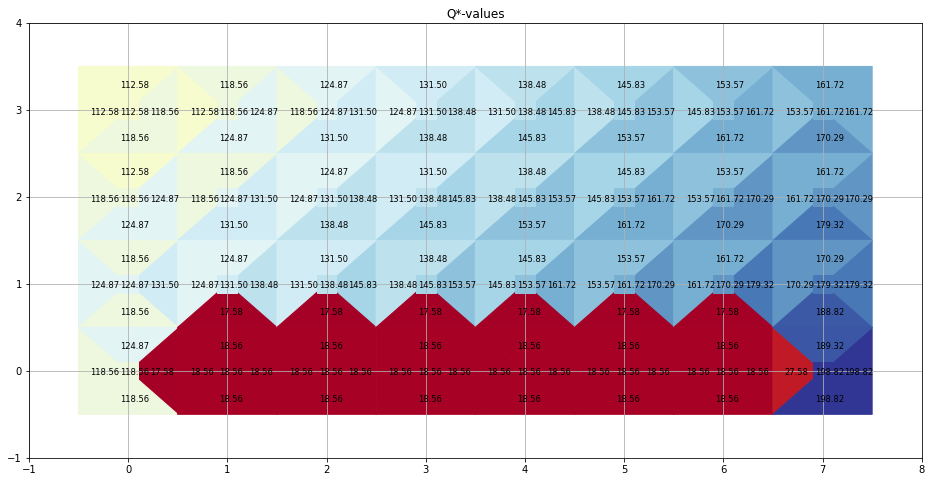

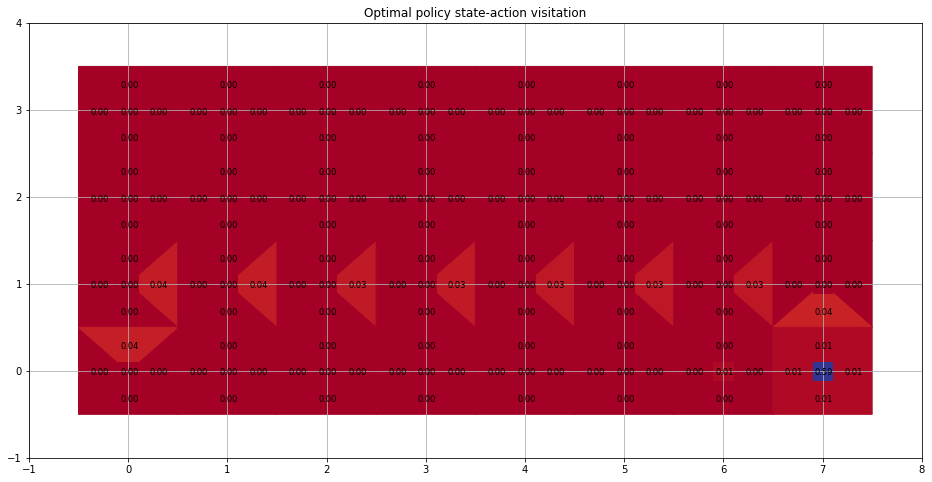

In [33]:
#@title Define environment and compute optimal Q-values
'''
maze = spec_from_string("SOOOOOO#\\"+
                        "O##O###O\\"+
                        "OO#OO##O\\"+
                        "O#RO#OO#\\"
                       )


maze = spec_from_string("OOOOOOOOOOOO\\"+
                        "OOOOOOOOOOOO\\"+
                        "OOOOOOOOOOOO\\"+
                        "SLLLLLLLLLLR\\"
                       )
'''
maze = spec_from_string("OOOOOOOO\\"+
                        "OOOOOOOO\\"+
                        "OOOOOOOO\\"+
                        "SLLLLLLR\\"
                       )
'''
maze = spec_from_string("OOOOOOOOOO\\"+
                        "OOOOOOOOOO\\"+
                        "OOOOOOOOOO\\"+
                        "OLLLOOLLLO\\"+
                        "OLLLOOLLLO\\"+
                        "OLLLOOLLLO\\"+
                        "SLLLLLLLLR\\"
                       )
'''
env = GridEnv(maze, observation_type=env_type, dim_obs=8)
optimal_qvalues = q_iteration(env, num_itrs=100, discount=0.95, render=False)

plot_sa_values(env, optimal_qvalues, title='Q*-values')

policy = compute_policy_deterministic(optimal_qvalues, eps_greedy=0.1)
sa_visitations = compute_visitation(env, policy)
plot_sa_values(env, sa_visitations, title='Optimal policy state-action visitation')

In [34]:
#@title Compute weights
np.random.seed(0)
if dataset_composition == 'optimal':
  """Distribution of the optimal policy (+ some noise)"""
  weights = sa_visitations
  weights = weights/ np.sum(weights)
elif dataset_composition == 'random':
  """A random disribution over states and actions""" 
  weights = np.random.uniform(size=env.num_states * env.num_actions)
  weights = np.reshape(weights, (env.num_states, env.num_actions))
  weights = weights/ np.sum(weights)
elif dataset_composition == 'random+optimal':
  """Mixture of random and optimal policies"""
  weights = sa_visitations / np.sum(sa_visitations)
  weights_rand = np.random.uniform(size=env.num_states * env.num_actions)
  weights_rand = np.reshape(weights_rand, (env.num_states, env.num_actions)) / np.sum(weights_rand)
  weights = (weights_rand + weights)/2.0
elif dataset_composition == 'mixed':
  """Mixture of policies corresponding to random Q-values"""
  num_policies_mix = 3
  weights = np.zeros_like(sa_visitations)
  for idx in range(num_policies_mix):
    rand_q_vals_idx = np.random.uniform(low=0.0, high=10.0, size=(env.num_states, env.num_actions))
    policy_idx = compute_policy_deterministic(rand_q_vals_idx, eps_greedy=0.1)
    sa_visitations_idx = compute_visitation(env, policy_idx)
    weights = weights + sa_visitations_idx
  weights = weights / np.sum(weights)

In [35]:
# @title Generate dataset
np.random.seed(0) # 0 for random for safe lava, 1 for optimal 
training_data_dist = np.zeros((env.num_states, env.num_actions))
if not weighting_only:
  weights_flatten = np.reshape(weights, -1)
  weights_flatten = weights_flatten/ np.sum(weights_flatten)
  dataset = np.random.choice(
      np.arange(env.num_states * env.num_actions),
      size=dataset_size, replace=True, p=weights_flatten
  )
  training_sa_pairs = [(int(val//env.num_actions), val % env.num_actions) for val in dataset]

  # Now sample (s', r) values for training as well
  training_dataset = []
  #training_data_dist = np.zeros((env.num_states, env.num_actions))
  for idx in range(len(training_sa_pairs)):
    s, a = training_sa_pairs[idx]
    prob_s_prime = env._transition_matrix[s, a]
    s_prime = np.random.choice(np.arange(env.num_states), p=prob_s_prime)
    r = env.reward(s, a, s_prime)
    training_dataset.append((s, a, r, s_prime))
    training_data_dist[s, a] += 1.0
else:
  # Using only weighting style dataset
  training_dataset = None
  training_data_dist = None

In [ ]:
import json
def np_encoder(object):
    if isinstance(object, np.generic):
        return object.item()
with open('ro_data.json', 'w') as f:
    json.dump(training_dataset, f, default=np_encoder)

In [ ]:

# read the file
with open('ro_data.json') as f:
   lst1 = [tuple(x) for x in json.load(f)]
   print(f'lst1: {lst1}')

lst1: [(24, 2, -1, 24), (31, 0, 0, 31), (27, 4, -100, 24), (24, 1, -1, 16), (21, 4, -1, 22), (29, 4, -100, 24), (21, 4, -1, 22), (31, 0, 0, 31), (31, 1, 0, 23), (20, 3, -1, 19), (31, 0, 0, 31), (24, 1, -1, 16), (25, 3, -100, 24), (31, 0, 0, 31), (3, 4, -1, 4), (4, 3, -1, 3), (1, 0, -1, 1), (31, 0, 0, 31), (31, 0, 0, 31), (31, 0, 0, 31), (31, 2, 0, 31), (31, 0, 0, 31), (22, 4, -1, 23), (31, 0, 0, 31), (6, 3, -1, 5), (29, 4, -100, 24), (8, 0, -1, 8), (31, 0, 0, 31), (24, 0, -1, 24), (21, 2, -1, 29), (16, 4, -1, 17), (31, 0, 0, 31), (22, 4, -1, 23), (25, 3, -100, 24), (1, 0, -1, 1), (28, 3, -100, 24), (28, 2, -100, 24), (28, 3, -100, 24), (31, 0, 0, 31), (31, 0, 0, 31), (19, 4, -1, 20), (21, 4, -1, 22), (31, 0, 0, 31), (3, 2, -1, 11), (31, 0, 0, 31), (31, 0, 0, 31), (13, 3, -1, 12), (7, 2, -1, 15), (18, 1, -1, 10), (19, 4, -1, 20), (25, 4, -100, 24), (21, 4, -1, 22), (31, 3, 0, 30), (5, 3, -1, 4), (13, 2, -1, 21), (9, 2, -1, 17), (30, 1, -100, 24), (16, 3, -1, 16), (22, 4, -1, 23), (16, 0

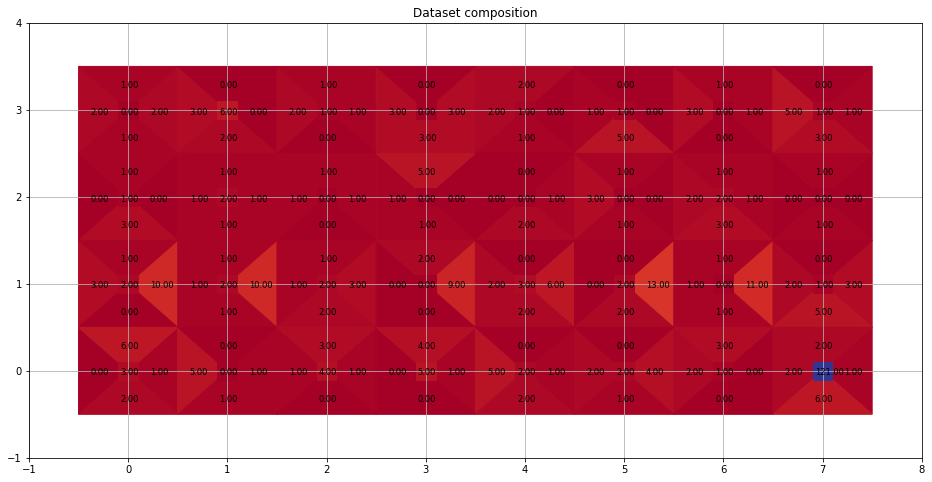

In [36]:
#@title Visualize dataset or weights
if not weighting_only:
  plot_sa_values(env, training_data_dist, title='Dataset composition')
else:
  plot_sa_values(env, weights, title='Weighting Distribution')

### Experiment 1: Naive Off-Policy RL

In this experiment, we will experiment with standard offline Q-learning in the absence of finite sampling error. As covered in Part 1 of the tutorial, these standard off-policy Q-learning algorithms suffer from distributional shift in the offline setting and overestimate values. 

We provide the code for measuring, plotting and visualizing the Q-values and the amount of overestimation in them. By playing around with different weighting schemes, answer the following questions:

- Is there a weighting distribution such that naive Q-learning does not overestimate values? (Hint: Try constructing the uniform weighting distribution and run FQI with it!)

- Which weighting distribution lead to the most overestimation? (Hint: Try the extremes, optimal-policy and a near-uniform distribution to arrive at the answer)

- How is the distribution of the learned policy different when Q-values at usneen actions are overestimated?

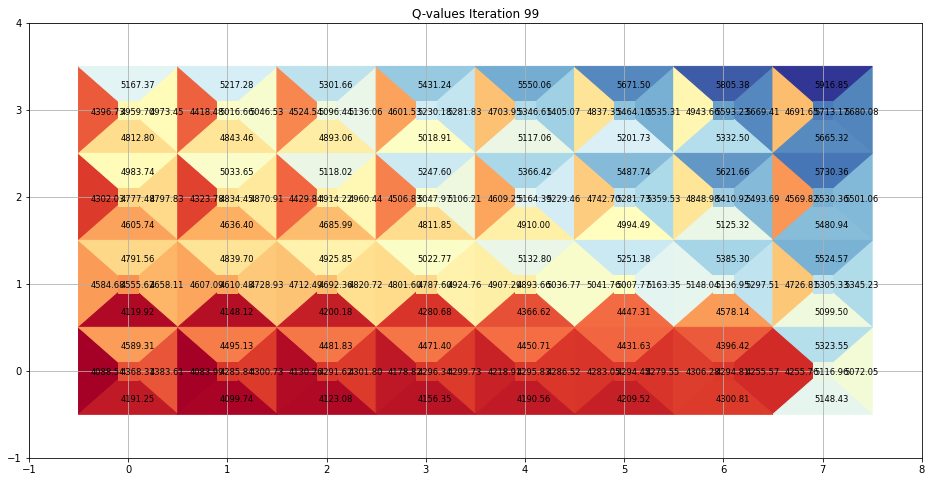

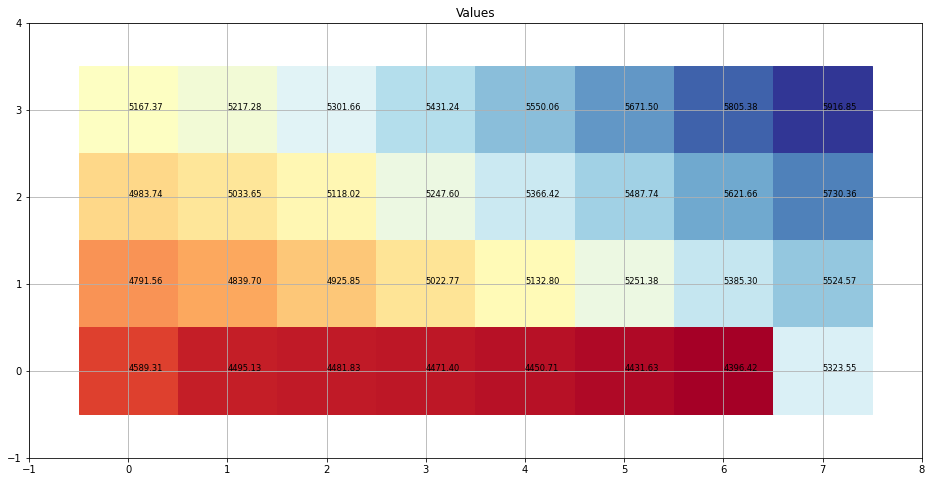

In [37]:
#@title Run regular fitted Q-iteration (or Q-learning)

# Weighting distribution
weights = sa_visitations

# Use a tabular or feedforward NN approximator
network = FCNetwork(env, layers=[20, 20])
#network = TabularNetwork(env)

# Run Q-iteration
q_values = fitted_q_iteration(env, network,
                              num_itrs=100, discount=0.95, 
                              weights=weights, render=True,
                              sampled=False)

# Compute and plot the value function
v_values = np.max(q_values, axis=1)
plot_s_values(env, v_values, title='Values')

Total Error: 758040.8722593009
Total Weighted Overestimation under the training distribution:  4842.600330686004
Total Overestimation under the learned policy:  5014.254892597982
Total Overestimation:  4737.755451620631


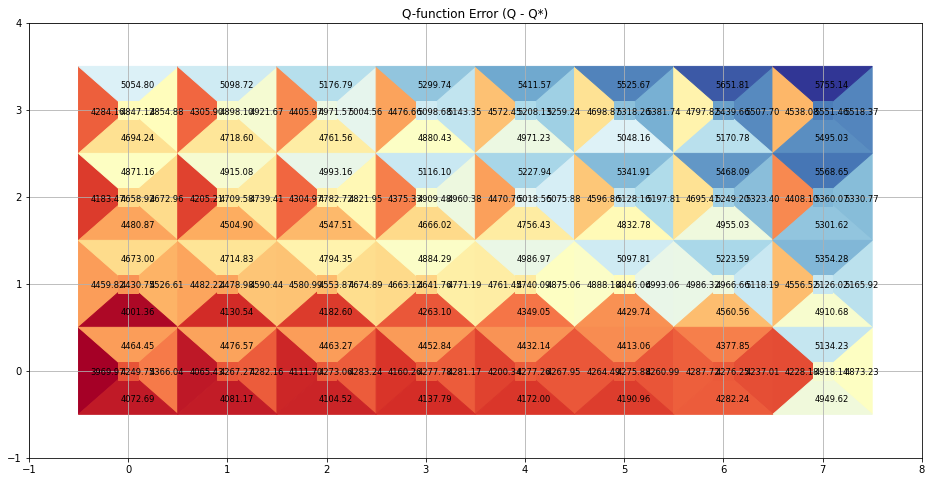

In [38]:
#@title Plot Q-functions, overestimation error

print('Total Error:', np.sum(np.abs(q_values - optimal_qvalues)))

# Compute over-estimation in the training distribution
total_overestimation = np.sum((q_values - optimal_qvalues) * weights)
print('Total Weighted Overestimation under the training distribution: ', total_overestimation)

# Compute over-estimation under the resulting policy
policy = compute_policy_deterministic(q_values, eps_greedy=0.1)
policy_sa_visitations = compute_visitation(env, policy)
weights_policy = policy_sa_visitations / np.sum(policy_sa_visitations)
total_policy_overestimation = np.sum((q_values - optimal_qvalues) * weights_policy)
print ('Total Overestimation under the learned policy: ', total_policy_overestimation)

# Compute unweighted overestimation
total_overestimation_unweighted = np.mean((q_values - optimal_qvalues))
print ('Total Overestimation: ', total_overestimation_unweighted)

plot_sa_values(env, (q_values - optimal_qvalues), title='Q-function Error (Q - Q*)')


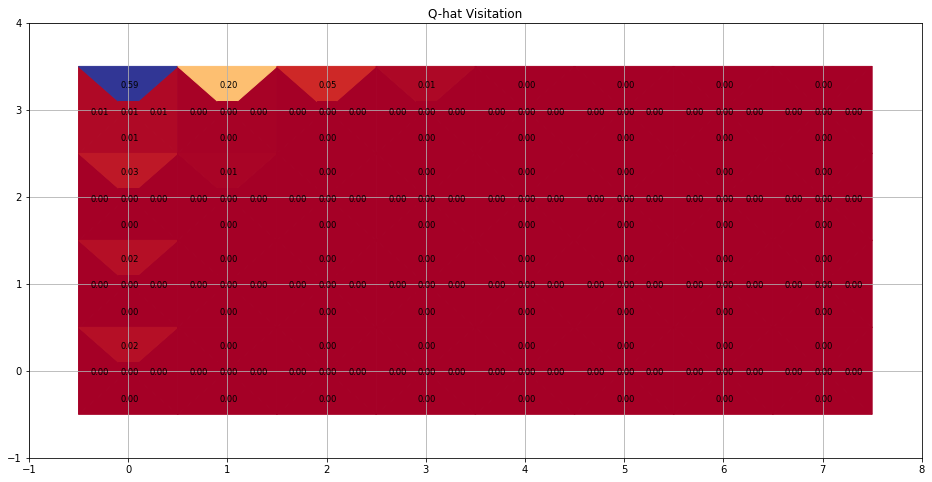

In [39]:
#@title Compute visitations of the learned policy
policy = compute_policy_deterministic(q_values, eps_greedy=0.1)
policy_sa_visitations = compute_visitation(env, policy)
plot_sa_values(env, policy_sa_visitations, title='Q-hat Visitation')

### Experiment 2: Correcting for Distributional Shift

In this experiment, we will experiment with the conservative Q-learning (CQL) algorithm that corrects for overestimation of unseen outcomes caused as a result of distributional shift. We've already implemented CQL in the Algorithms section of this colab, and here you will experiment with some design choices such as setting the strength of the constraint ($\alpha$) and you will also measure overestimation in Q-values, and visualize the resulting policy. Try answering the following questions in this experiment:

- Is CQL able to prevent overestimation that arises in standard off-policy Q-learning as a result for distributional shift compared to that observed in Experiment 1 with the same value of `weighting_scheme`? 

- How do different variants of CQL (v1 vs v2) behave in this setting? To toggle between v1 and v2, check out the  Algorithm block of this colab.

- Does CQL learn policies closer to the optimal policy unlike naive off-policy Q-learning? (It should for reasonable values of `cql_alpha`)

- How do the values of $\alpha$ (`cql_alpha` parameter in code) affect the performance of CQL? (We would expect that very small values of $\alpha$ are unable to prevent overestimation, some medium values of $\alpha$ effectively balance conservatism and policy learning, while large values of $\alpha$ give rise to overly conservative solutions.)

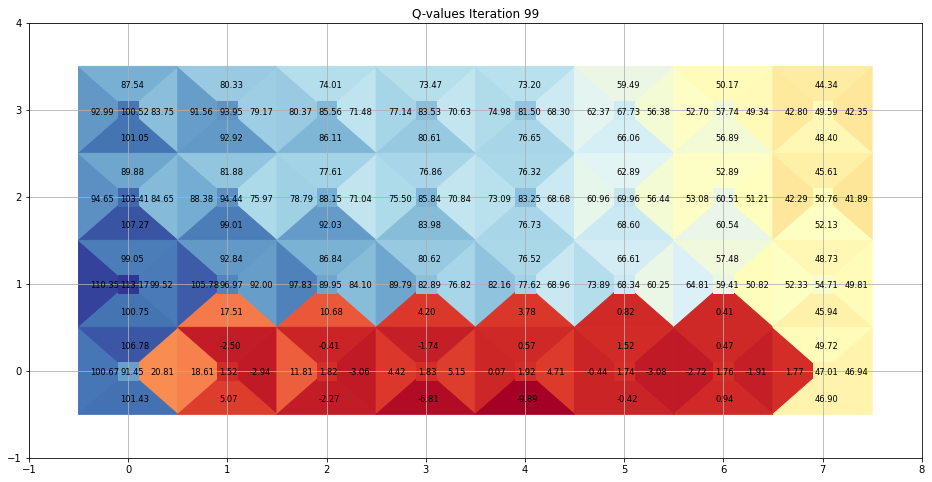

lava counts cql []


In [ ]:
#@title Run conservative Q-iteration (or CQL)

# Use a tabular or feedforward NN approximator
network = FCNetwork(env, layers=[20, 20])
#network = TabularNetwork(env)

cql_alpha_val = 0.1 # @param {type:"slider", min:0.0, max:10.0, step:0.1}

# Run Q-iteration
q_values = conservative_q_iteration(env, network,
                                    num_itrs=100, discount=0.95, cql_alpha=cql_alpha_val, 
                                    weights=weights, render=True)

# Compute and plot the value function
#v_values = np.max(q_values, axis=1)
#plot_s_values(env, v_values, title='Values')

Total Error: 6728.497270492655
Total Weighted Overestimation under the training distribution:  26.77003792550301
Total Overestimation under the learned policy:  56.86160179110008
Total Overestimation:  42.05310794057908


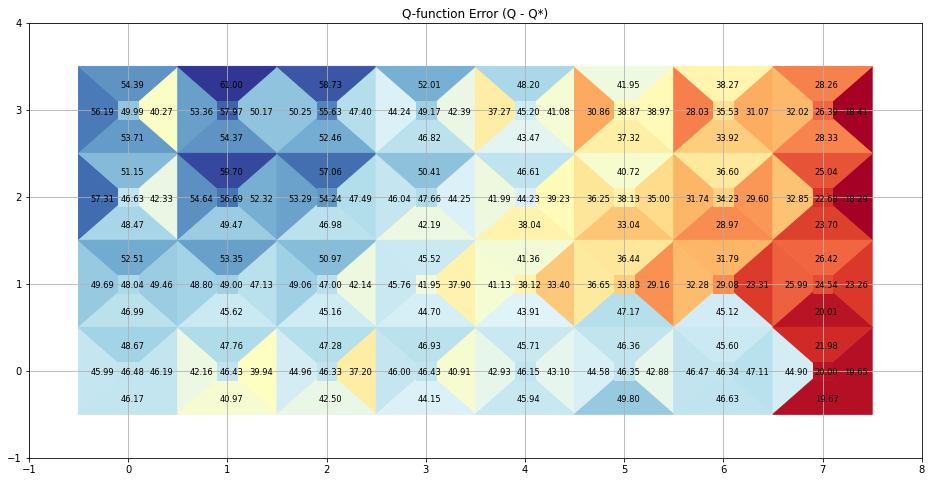

In [ ]:
#@title Plot Q-functions, overestimation error

print('Total Error:', np.sum(np.abs(q_values - optimal_qvalues),dtype='object'))

# Compute over-estimation in the training distribution
total_overestimation = np.sum((q_values - optimal_qvalues) * weights)
print('Total Weighted Overestimation under the training distribution: ', total_overestimation)

# Compute over-estimation under the resulting policy
policy = compute_policy_deterministic(q_values, eps_greedy=0.1)
policy_sa_visitations = compute_visitation(env, policy)
weights_policy = policy_sa_visitations / np.sum(policy_sa_visitations)
total_policy_overestimation = np.sum((q_values - optimal_qvalues) * weights_policy)
print ('Total Overestimation under the learned policy: ', total_policy_overestimation)

# Compute unweighted overestimation
total_overestimation_unweighted = np.mean((q_values - optimal_qvalues))
print ('Total Overestimation: ', total_overestimation_unweighted)

plot_sa_values(env, (q_values - optimal_qvalues), title='Q-function Error (Q - Q*)')


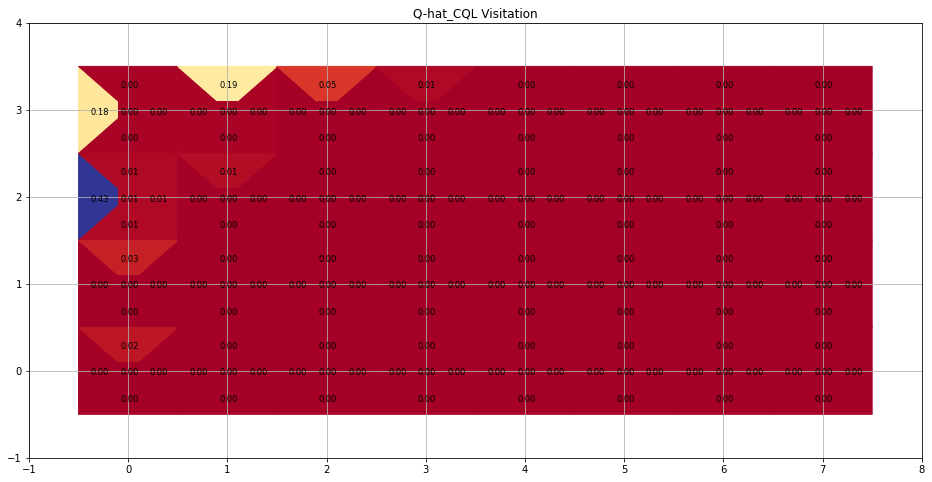

In [ ]:
#@title Compute visitations of the learned policy
policy = compute_policy_deterministic(q_values, eps_greedy=0.1)
policy_sa_visitations = compute_visitation(env, policy)
plot_sa_values(env, policy_sa_visitations, title='Q-hat_CQL Visitation')

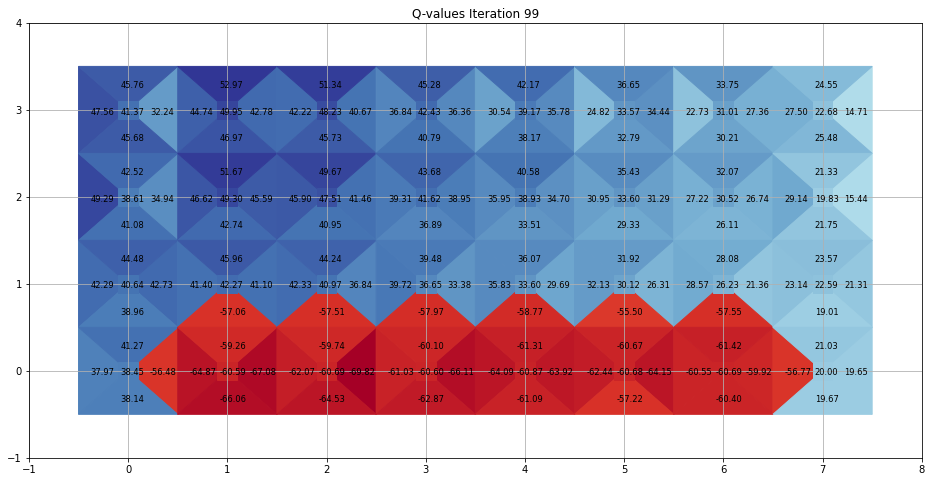

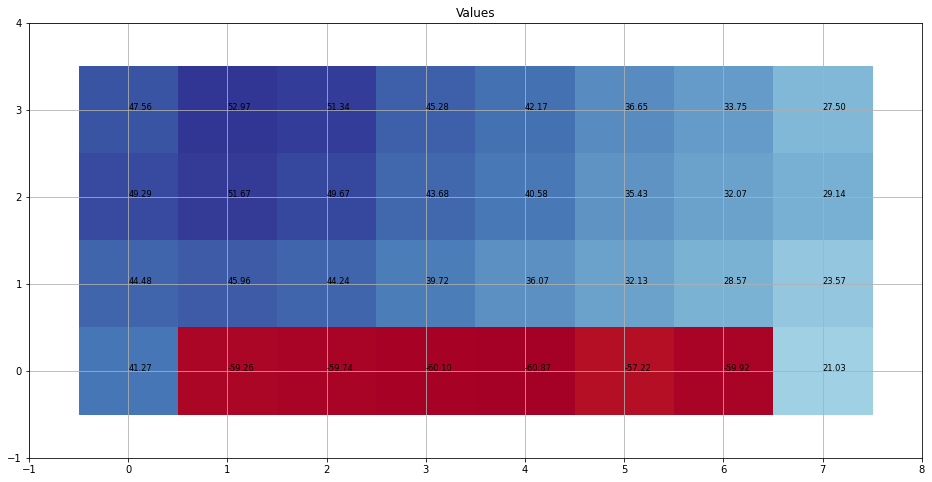

In [ ]:
#@title Run safe conservative Q-iteration (or CQL)

# Use a tabular or feedforward NN approximator
network = FCNetwork(env, layers=[20, 20])
#network = TabularNetwork(env)

cql_alpha_val = 0.1 # @param {type:"slider", min:0.0, max:10.0, step:0.1}

# Run Q-iteration
q_values = safeconservative_q_iteration(env, network, training_data_dist,
                                    num_itrs=100, discount=0.95, cql_alpha=cql_alpha_val, 
                                    weights=weights, render=True)

# Compute and plot the value function
v_values = np.max(q_values, axis=1)
plot_s_values(env, v_values, title='Values')

Total Error: 6728.497270492653
Total Weighted Overestimation under the training distribution:  26.77003792550301
Total Overestimation under the learned policy:  56.86160179110008
Total Overestimation:  42.05310794057908


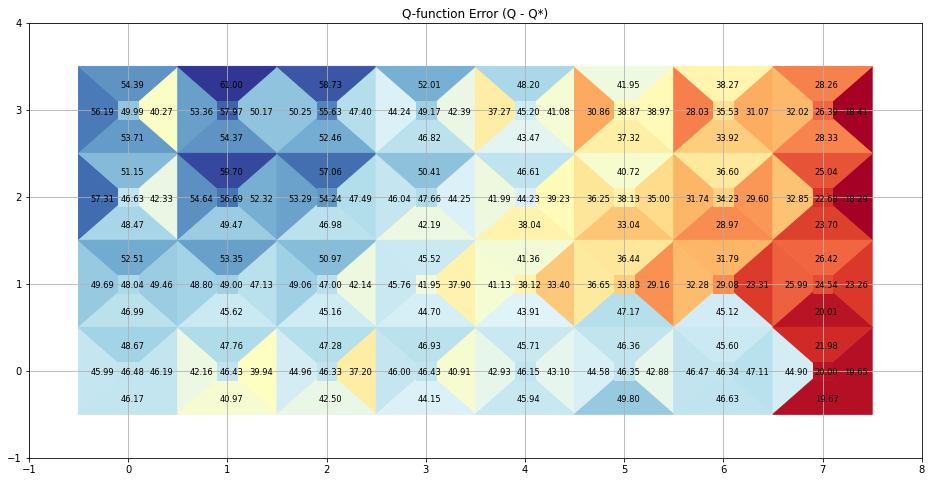

In [ ]:
#@title Plot Q-functions, overestimation error

print('Total Error:', np.sum(np.abs(q_values - optimal_qvalues)))

# Compute over-estimation in the training distribution
total_overestimation = np.sum((q_values - optimal_qvalues) * weights)
print('Total Weighted Overestimation under the training distribution: ', total_overestimation)

# Compute over-estimation under the resulting policy
policy = compute_policy_deterministic(q_values, eps_greedy=0.1)
policy_sa_visitations = compute_visitation(env, policy)
weights_policy = policy_sa_visitations / np.sum(policy_sa_visitations)
total_policy_overestimation = np.sum((q_values - optimal_qvalues) * weights_policy)
print ('Total Overestimation under the learned policy: ', total_policy_overestimation)

# Compute unweighted overestimation
total_overestimation_unweighted = np.mean((q_values - optimal_qvalues))
print ('Total Overestimation: ', total_overestimation_unweighted)

plot_sa_values(env, (q_values - optimal_qvalues), title='Q-function Error (Q - Q*)')


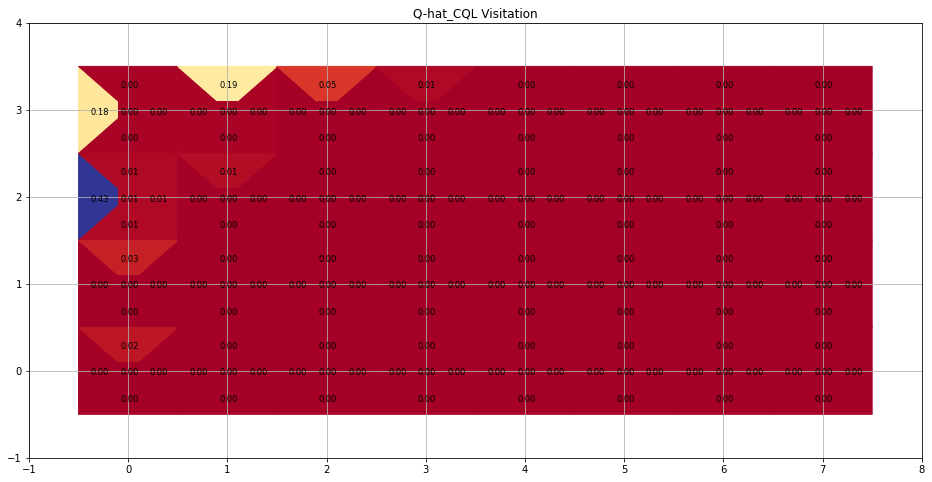

In [ ]:
#@title Compute visitations of the learned policy
policy = compute_policy_deterministic(q_values, eps_greedy=0.1)
policy_sa_visitations = compute_visitation(env, policy)
plot_sa_values(env, policy_sa_visitations, title='Q-hat_CQL Visitation')

### Experiment 3: Offline RL with Distributional Shift + Finite Samples

In this expeirment, we will see how finite sampling error affects the performance of offline RL alongside distributional shift. In addition to a distribution over state-action pairs, we will not be able to compute the exact target value for the Bellman backup since we only observe one (or few) next-state samples given a state-actio pair. Repeat experiments 1 and 2 in this setup with varying number of datapoints in the dataset.
In particular, answer the following questions:

- How does the amount of finite data affect the performance of offline RL algorithms that do and do not correct for distributional shift? (Try running FQI and CQL with weighting schemes from before, but with sampling, i.e., uncheck `weighting_only` for this part, and note that sensitivity to dataset size is higher with narrow data-distributions.) With large amounts of data, you should find that the performance of FQI and CQL are similar to Experiments 1 and 2 repsectively.

- Train for varying amounts of steps with the CQL regularizer in the setting when the size of the dataset (controlled by setting ``dataset_size``) is small (e.g., <= 50). You will mostly find that the performance starts degrading once trained for long enough especially with small-medium sized datasets. This was discussed in the OPE section of the tutorial and neccessitates the development of effective policy selection strategies. While we did not implement OPE in this colab, implementing a method for policy selection such as fitted Q-evaluation (FQE) should be straightforward and it would be an interesting exercise to see if it can find out the best policy of all policy iterates found by CQL.    


#### Experiment 1 with Finite Data

In [40]:
#@title Run regular fitted Q-iteration with finite data

# Use a tabular or feedforward NN approximator
network = FCNetwork(env, layers=[20, 20])
#network = TabularNetwork(env)

# Run Q-iteration
q_values = fitted_q_iteration(env, network,
                              num_itrs=100, discount=0.95, 
                              weights=weights, render=True,
                              sampled=not(weighting_only),
                              training_dataset=training_dataset)

# Compute and plot the value function
v_values = np.max(q_values, axis=1)
plot_s_values(env, v_values, title='Values')



<ipython-input-28-e168b9432a7e>:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  target_qvalues = torch.tensor(target_values, dtype=torch.float32)


TypeError: ignored

Total Error: 10094.153313702838
Total Weighted Overestimation under the training distribution:  21.43187919366093
Total Overestimation under the learned policy:  32.567931475513234
Total Overestimation:  41.45168371836798


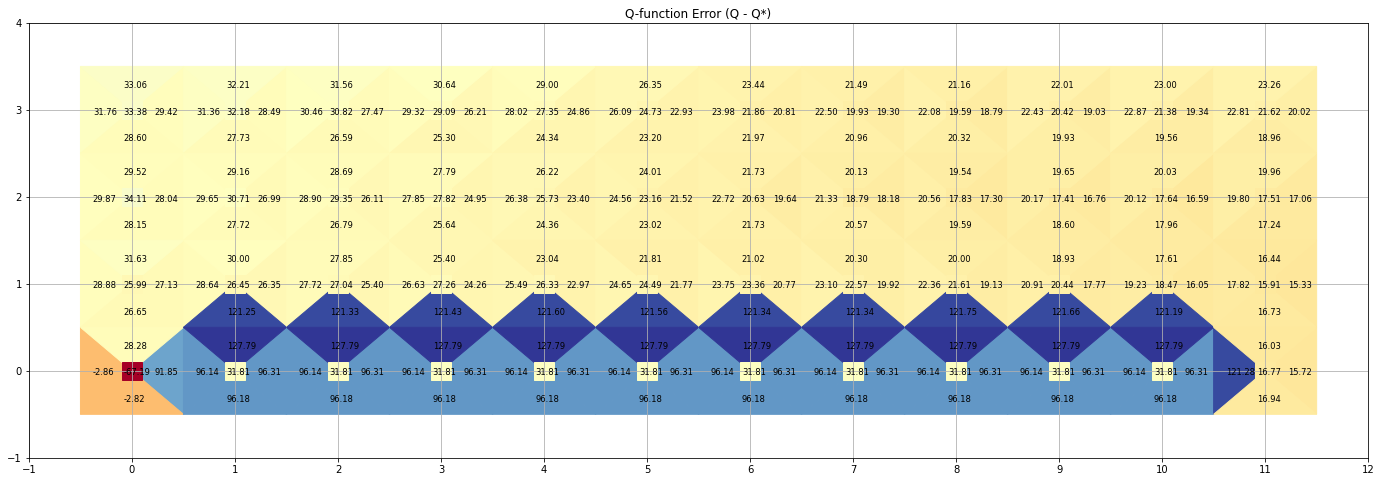

In [ ]:
#@title Plot Q-functions, overestimation error

print('Total Error:', np.sum(np.abs(q_values - optimal_qvalues)))

# Compute over-estimation in the training distribution
total_overestimation = np.sum((q_values - optimal_qvalues) * weights)
print('Total Weighted Overestimation under the training distribution: ', total_overestimation)

# Compute over-estimation under the resulting policy
policy = compute_policy_deterministic(q_values, eps_greedy=0.1)
policy_sa_visitations = compute_visitation(env, policy)
weights_policy = policy_sa_visitations / np.sum(policy_sa_visitations)
total_policy_overestimation = np.sum((q_values - optimal_qvalues) * weights_policy)
print ('Total Overestimation under the learned policy: ', total_policy_overestimation)

# Compute unweighted overestimation
total_overestimation_unweighted = np.mean((q_values - optimal_qvalues))
print ('Total Overestimation: ', total_overestimation_unweighted)

plot_sa_values(env, (q_values - optimal_qvalues), title='Q-function Error (Q - Q*)')


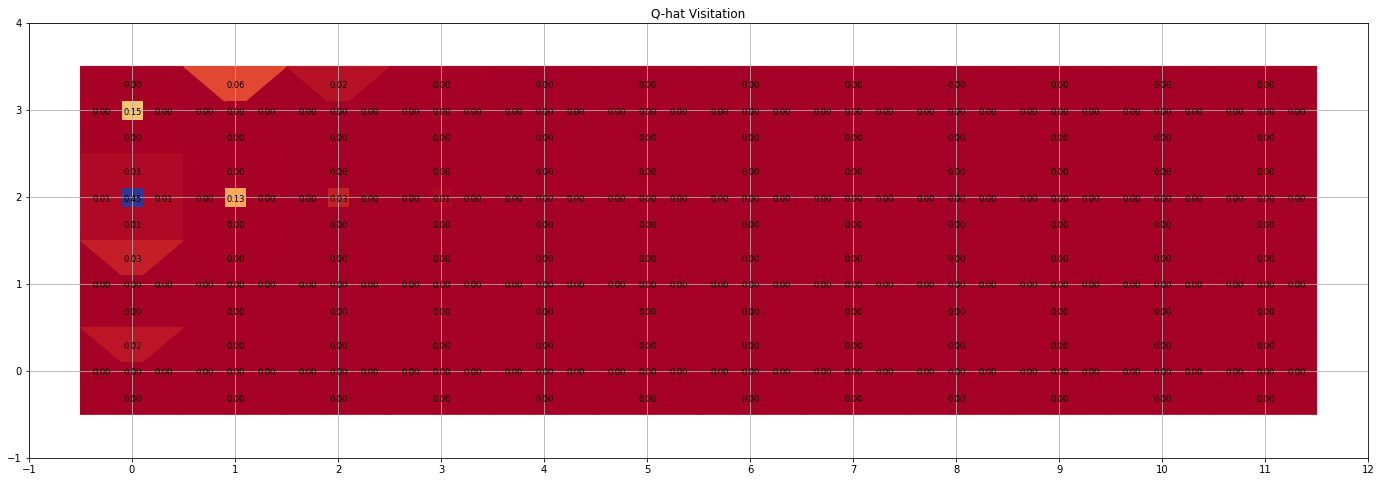

In [ ]:
#@title Compute visitations of the learned policy
policy = compute_policy_deterministic(q_values, eps_greedy=0.1)
policy_sa_visitations = compute_visitation(env, policy)
plot_sa_values(env, policy_sa_visitations, title='Q-hat Visitation')

#### Experiment 2 with Finite Data

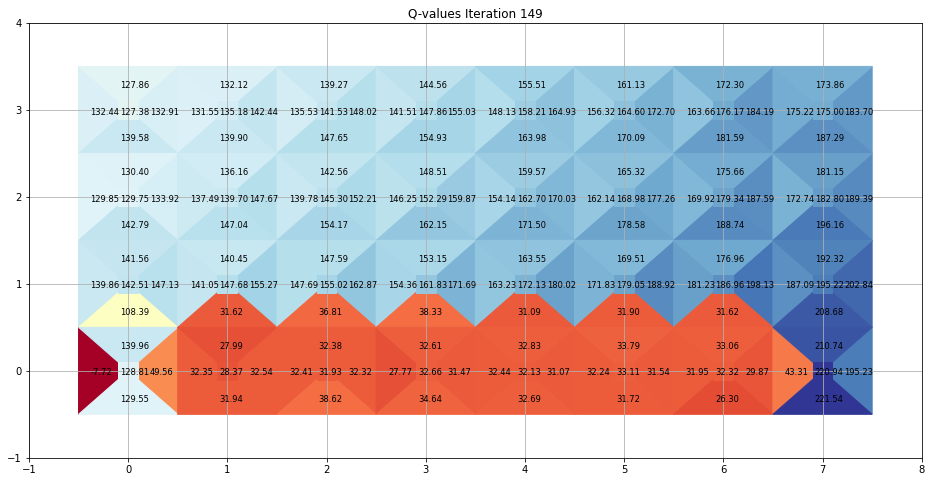

lava counts cql [2, 8, 2, 3, 5, 4, 2, 5, 4, 5, 6, 0, 8, 5, 3, 2, 1, 4, 3, 2, 5, 5, 4, 3, 3, 5, 5, 1, 3, 2, 5, 2, 1, 4, 3, 3, 1, 2, 4, 2, 4, 2, 3, 3, 4, 2, 2, 3, 1, 3, 24, 19, 29, 28, 14, 19, 25, 32, 19, 16, 24, 28, 24, 27, 28, 26, 22, 27, 25, 26, 19, 23, 28, 22, 17, 20, 29, 28, 14, 27, 22, 25, 17, 21, 26, 27, 23, 26, 26, 27, 29, 25, 24, 23, 30, 28, 21, 22, 30, 24, 20, 23, 24, 22, 20, 20, 19, 25, 26, 28, 19, 20, 14, 26, 26, 33, 26, 27, 28, 24, 21, 21, 25, 23, 26, 21, 19, 21, 28, 27, 26, 26, 23, 25, 19, 25, 15, 26, 28, 23, 24, 23, 32, 27, 25, 25, 26, 22, 24, 20, 21, 18, 20, 28, 27, 27, 22, 27, 33, 25, 16, 20, 17, 20, 26, 24, 12, 27, 19, 30, 24, 18, 21, 19, 22, 25, 23, 18, 23, 28, 32, 20, 15, 22, 21, 15, 26, 35, 27, 22, 22, 23, 23, 24, 21, 29, 14, 27, 22, 20, 18, 24, 29, 28, 27, 33, 28, 21, 28, 30, 25, 25, 26, 25, 27, 21, 13, 23, 27, 22, 13, 23, 27, 28, 28, 22, 22, 23, 18, 25, 21, 28, 23, 25, 28, 24, 28, 28, 19, 25, 33, 18, 26, 23, 15, 22, 18, 22, 27, 26, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

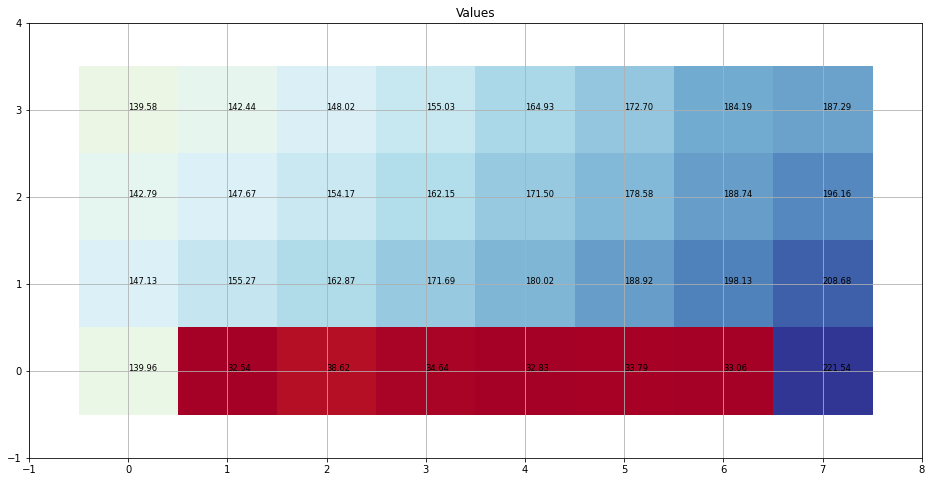

In [41]:

#@title Run conservative Q-iteration (or CQL) with finite data

# Use a tabular or feedforward NN approximator
network = FCNetwork(env, layers=[20, 20])
#network = TabularNetwork(env)

cql_alpha_val = 0.1 # @param {type:"slider", min:0.0, max:10.0, step:0.01}

print (weighting_only)
# Run Q-iteration
q_values, lava_cql = conservative_q_iteration(env, network,
                                    num_itrs=150, discount=0.95, cql_alpha=cql_alpha_val, 
                                    weights=weights, render=True,
                                    sampled=not(weighting_only),
                                    training_dataset=training_dataset)

# Compute and plot the value function
v_values = np.max(q_values, axis=1)
plot_s_values(env, v_values, title='Values')

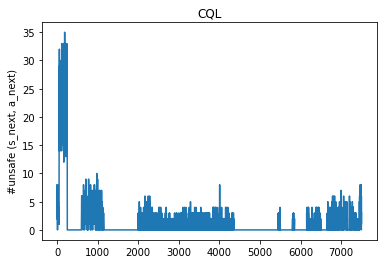

7500


In [42]:
import matplotlib.pyplot as plt
plt.plot(lava_cql)
plt.ylabel('#unsafe (s_next, a_next)')
plt.title('CQL')
plt.show()
print(len(lava_cql))

Total Error: 2700.424802008206
Total Weighted Overestimation under the training distribution:  19.83714471432541
Total Overestimation under the learned policy:  20.203935833721935
Total Overestimation:  15.127213318161898


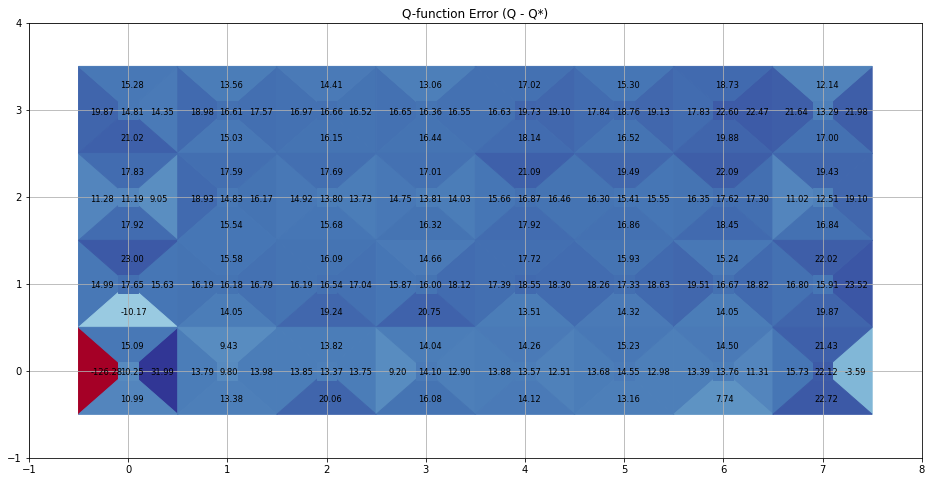

In [43]:
#@title Plot Q-functions, overestimation error

print('Total Error:', np.sum(np.abs(q_values - optimal_qvalues)))

# Compute over-estimation in the training distribution
total_overestimation = np.sum((q_values - optimal_qvalues) * weights)
print('Total Weighted Overestimation under the training distribution: ', total_overestimation)

# Compute over-estimation under the resulting policy
policy = compute_policy_deterministic(q_values, eps_greedy=0.1)
policy_sa_visitations = compute_visitation(env, policy)
weights_policy = policy_sa_visitations / np.sum(policy_sa_visitations)
total_policy_overestimation = np.sum((q_values - optimal_qvalues) * weights_policy)
print ('Total Overestimation under the learned policy: ', total_policy_overestimation)

# Compute unweighted overestimation
total_overestimation_unweighted = np.mean((q_values - optimal_qvalues))
print ('Total Overestimation: ', total_overestimation_unweighted)

plot_sa_values(env, (q_values - optimal_qvalues), title='Q-function Error (Q - Q*)')


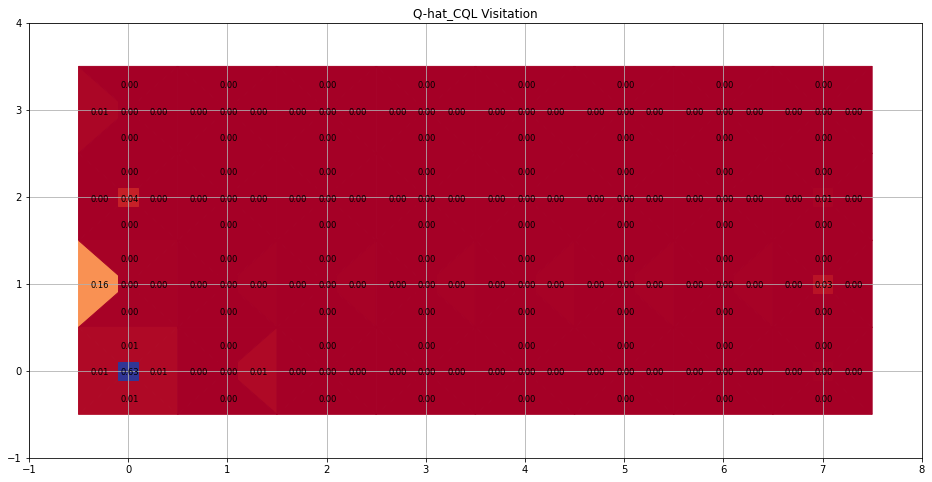

In [47]:
#@title Compute visitations of the learned policy
policy = compute_policy_deterministic(q_values, eps_greedy=0.1)
policy_sa_visitations = compute_visitation(env, policy)
plot_sa_values(env, policy_sa_visitations, title='Q-hat_CQL Visitation')

#### Experiment 3 with Finite Data

In [ ]:
#@title Run safe conservative Q-iteration (or CQL) with finite data

# Use a tabular or feedforward NN approximator
network = FCNetwork(env, layers=[20, 20])
#network = TabularNetwork(env)

cql_alpha_val = 0.1 # @param {type:"slider", min:0.0, max:10.0, step:0.01}

print (weighting_only)
#print(training_data_dist.shape)
# Run Q-iteration
q_values = safeconservative_q_iteration(env, network, training_data_dist,
                                    num_itrs=140, discount=0.95, cql_alpha=cql_alpha_val, 
                                    weights=weights, render=True,
                                    sampled=not(weighting_only),
                                    training_dataset=training_dataset)

# Compute and plot the value function
v_values = np.max(q_values, axis=1)
plot_s_values(env, v_values, title='Values')

In [ ]:
#@title Plot Q-functions, overestimation error

print('Total Error:', np.sum(np.abs(q_values - optimal_qvalues)))

# Compute over-estimation in the training distribution
total_overestimation = np.sum((q_values - optimal_qvalues) * weights)
print('Total Weighted Overestimation under the training distribution: ', total_overestimation)

# Compute over-estimation under the resulting policy
policy = compute_policy_deterministic(q_values, eps_greedy=0.1)
policy_sa_visitations = compute_visitation(env, policy)
weights_policy = policy_sa_visitations / np.sum(policy_sa_visitations)
total_policy_overestimation = np.sum((q_values - optimal_qvalues) * weights_policy)
print ('Total Overestimation under the learned policy: ', total_policy_overestimation)

# Compute unweighted overestimation
total_overestimation_unweighted = np.mean((q_values - optimal_qvalues))
print ('Total Overestimation: ', total_overestimation_unweighted)

plot_sa_values(env, (q_values - optimal_qvalues), title='Q-function Error (Q - Q*)')


In [ ]:
#@title Compute visitations of the learned policy
policy = compute_policy_deterministic(q_values, eps_greedy=0.1)
policy_sa_visitations = compute_visitation(env, policy)
plot_sa_values(env, policy_sa_visitations, title='Q-hat_CQL Visitation')

#### Experiment 4 with Finite Data

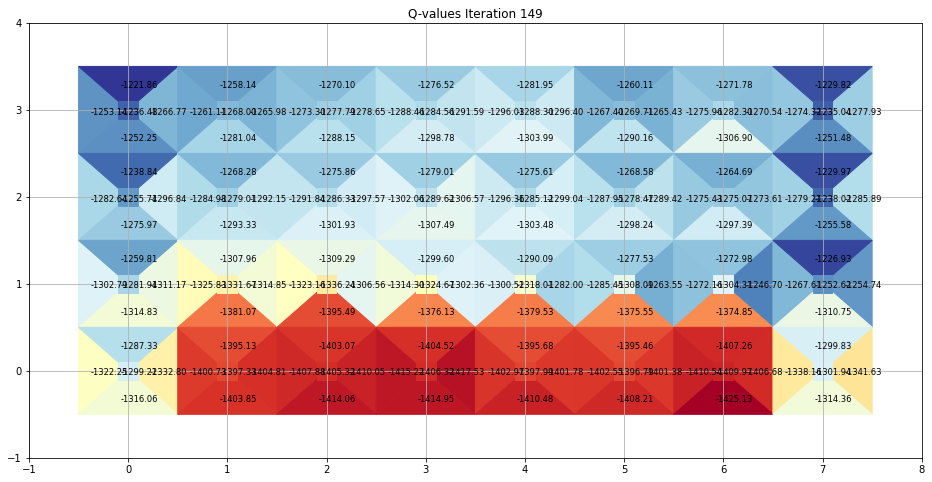

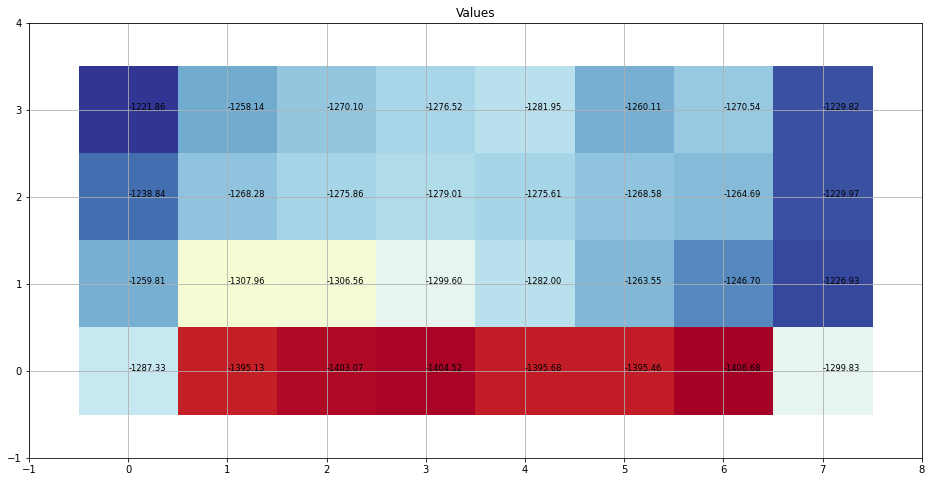

In [52]:
#@title Run heuristic + safe conservative Q-iteration (or CQL) with finite data

# Use a tabular or feedforward NN approximator
network = FCNetwork(env, layers=[20, 20])
#network = TabularNetwork(env)

cql_alpha_val = 0.1 # @param {type:"slider", min:0.0, max:10.0, step:0.01}

print (weighting_only)
#print(training_data_dist.shape)
# Run Q-iteration
q_values, lava_safecql = safe_heu_conservative_q_iteration(env, network, training_data_dist,
                                    num_itrs=150, discount=0.95, cql_alpha=cql_alpha_val, 
                                    weights=weights, render=True,
                                    sampled=not(weighting_only),
                                    training_dataset=training_dataset)

# Compute and plot the value function
v_values = np.max(q_values, axis=1)
plot_s_values(env, v_values, title='Values')

In [53]:
print(env.gs.height)
print(env.gs.width)
print(env.gs.spec)

4
8
[[110 110 110 112]
 [110 110 110 118]
 [110 110 110 118]
 [110 110 110 118]
 [110 110 110 118]
 [110 110 110 118]
 [110 110 110 118]
 [110 110 110 113]]


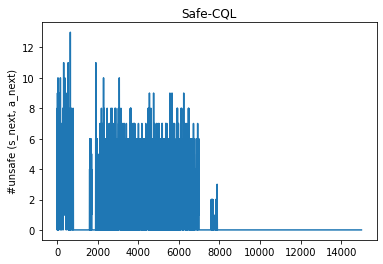

In [54]:
import matplotlib.pyplot as plt
plt.plot(lava_safecql)
plt.ylabel('#unsafe (s_next, a_next)')
plt.title('Safe-CQL')
plt.show()

Total Error: 228025.5371645271
Total Weighted Overestimation under the training distribution:  -1479.4973466073993
Total Overestimation under the learned policy:  -1353.5136229527145
Total Overestimation:  -1425.1596072782945


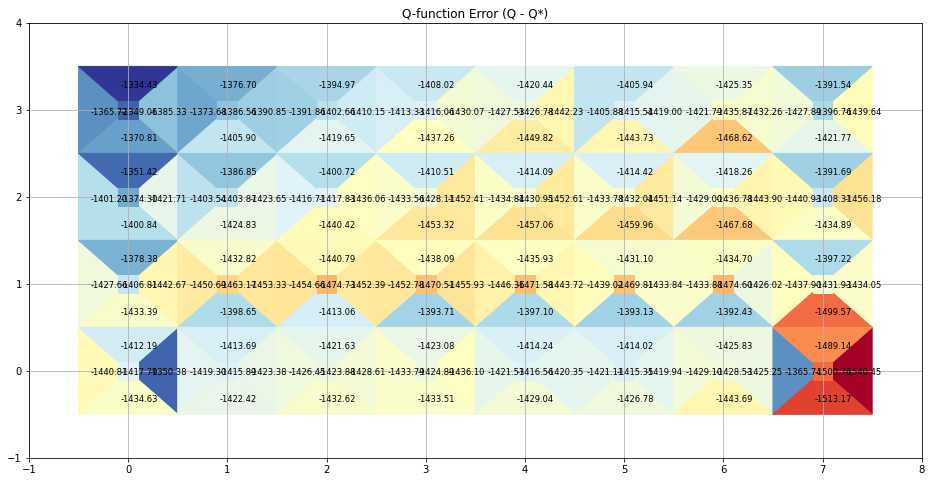

In [55]:
#@title Plot Q-functions, overestimation error

print('Total Error:', np.sum(np.abs(q_values - optimal_qvalues)))

# Compute over-estimation in the training distribution
total_overestimation = np.sum((q_values - optimal_qvalues) * weights)
print('Total Weighted Overestimation under the training distribution: ', total_overestimation)

# Compute over-estimation under the resulting policy
policy = compute_policy_deterministic(q_values, eps_greedy=0.1)
policy_sa_visitations = compute_visitation(env, policy)
weights_policy = policy_sa_visitations / np.sum(policy_sa_visitations)
total_policy_overestimation = np.sum((q_values - optimal_qvalues) * weights_policy)
print ('Total Overestimation under the learned policy: ', total_policy_overestimation)

# Compute unweighted overestimation
total_overestimation_unweighted = np.mean((q_values - optimal_qvalues))
print ('Total Overestimation: ', total_overestimation_unweighted)

plot_sa_values(env, (q_values - optimal_qvalues), title='Q-function Error (Q - Q*)')


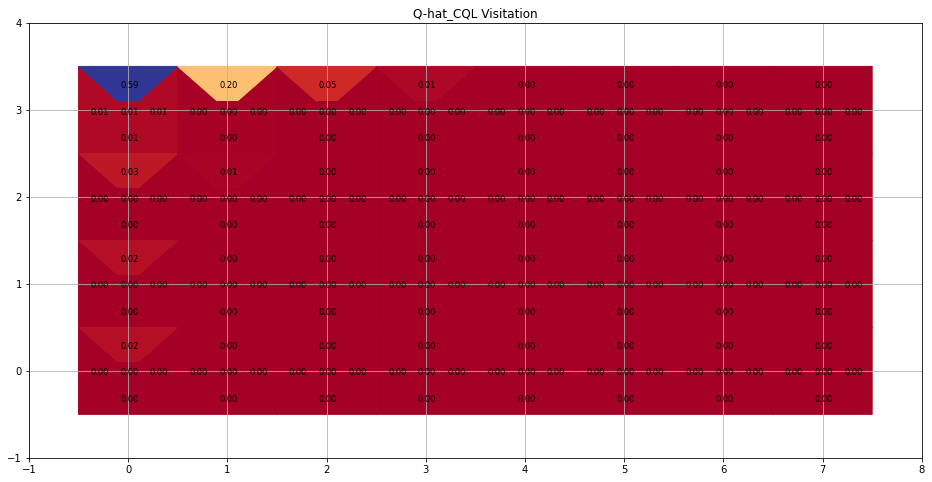

In [56]:
#@title Compute visitations of the learned policy
policy = compute_policy_deterministic(q_values, eps_greedy=0.1)
policy_sa_visitations = compute_visitation(env, policy)
plot_sa_values(env, policy_sa_visitations, title='Q-hat_CQL Visitation')